Danish Library Loan Data

[Motivation](#cell1)
- [Why libraries](#cell2)
- [The dataset](#cell3)
- [Our vision](#cell4)
   
[Basic stats](#cell5)
- [Preprocessing](#cell6)
- [Data exploration](#cell7)
    - [Most rented books](#cell8)
    - [Time of the year](#cell9)
    - [Gender differences](#cell10)
    - [Age tendencies](#cell12)
    - [Miscellaneous graphs](#cell13)
       
[Denmark map, municipalities](#cell14)
- [Why a map](#cell15)
- [Step 1: Cleaning loaner age and DK5 columns](#cell16)
- [Step 2: Matching with postnummer](#cell17)
- [Step 3: Matching postnummer with kommune](#cell18)
- [Step 4: Relative dk5 distribution of each kommune](#cell19)

[Denmark map, KNN](#cell20)
- [Why KNN](#cell21)
- [Step 1: Cleaning location data](#cell22)
- [Step 2: Merging location with loans](#cell23)
- [Step 3: Relative dk5 distribution of each library](#cell24)
- [Step 4: Create lon/lat points](#cell25)
- [Step 5: Grid and data preperation](#cell26)
- [Step 6: Chosing Knn algorithm](#cell27)
- [Step 7: Train and predict](#cell28)

[Real machine learning...](#cell29)
- [Linear regression](#cell30)
    - [Why Lreg](#cell31)
    - [Limitations](#cell32)
    - [What to expect](#cell33)
    - [R value](#cell34)
- [Classification](#cell35)
    - [Level of generalization](#cell36)
- [Decision Tree](#cell37)
    - [Accuracy](#cell38)
- [Artificial neural network](#cell39)
    - [Performance](#cell60)
- [Increase # bins](#cell61)
    - [Decision tree change](#cell62)
- [Association rules](#cell63)
    - [Step 1: Grouping loans](#cell64)
    - [Step 2: Mining Frequent Itemsets](#cell65)
    - [Step 3: Mining Association Rules](#cell66)

[Visuals](#cell40)
- [Bar charts](#cell40)
- [Map of municipalities](#cell41)
- [KNN map](#cell42)
- [Ascociation rules](#cell43)

[Discussion](#cell50)
- [Good stuff](#cell51)
- [Less good stuff](#cell52)

<a id="cell1"></a>
<a id="cell2"></a>

# Motivation
### Why libraries
From the beginning we had a desire to work on data related to Denmark. We found it interesting to (hopefully) gain insights that was  relatable to our everyday. Initially we therefor looked through open data provided by the Copenhagen Municipality and trawled through datasets for parking, bike data and housing rentals. They all lacked the large quantity that we had experienced from the SF data, and often it was hard to figure out how to apply machine learning.

From the website hack4dk we stumbled across a dataset containing library loans across Denmark. We immediatly got the idea of visualizing some sort of loan tendencies on a map of Denmark with d3, and also had hopes that machine learning could help us understand loaners based upon regional, age and gender differences that might exist. Initially our idea was to create a service that could recomend books based upon you age, gender and geolocation, but we ended up shifting our focus to helping the library itself with figuring out what books to aquire.

<a id="cell3"></a>

### The dataset
The primary dataset of ~ 3,5 GB consisted of loans from 2009-2016 (around 60 mio loans!). Along this followed another set containing info regarding all titles on the danish libraries ( ~ 3,3GB) and a third dataset with information on all the individual libraries. We figured that libraries was a somewhat "unsexy" topic that there hadn't been done a lot work with - the more interesting.

<a id="cell4"></a>

### Our vision

We want to help libraries select the best books for their loaner segments and prevent libraries from investing in books that are very rarely, or never, loaned. Understanding that there are substantial differences between the titles different genders at different age spans in different regions of Denmark borrow, is a complex matter. Our purpose with this project is to invite librarians into the world of data visualisation and machine learning, so that we can at some point create a service which act as the right hand of libarians - the geeniebook.

*Example usecases are many, to mention a few:*

**A library located in western Jutland want to atract more young male loaners - which books should they aquire?**
  - *Looking at the most popular titles for this loaner group in regions nearby might help* 
  
**It's early June on Zealand, which book genres should be put on display at the library podium to generate most traction?**
  - *Figuring out what genres are trending at this time of the year within Zealand is a good indicator*
  
**The book "how to mix coctails" is very popular, if we want to add a book that can support the same loaner need, what title should we aquire?**
  - *Using machine learning to create associations between titles can help us predict which books usually lead to one another*
 

<a id="cell5"></a>

# Basic stats

#### Load modules for working with data
We love pandas and use it for almost everything!

In [1]:
#First off importing the data
import numpy as np
import pandas as pd
from pandas import DataFrame, Series

import datetime
import pandas.io.data
%matplotlib inline

C:\Users\Jonatan\Anaconda2\lib\site-packages\pandas\io\data.py:33: FutureWarning: 
The pandas.io.data module is moved to a separate package (pandas-datareader) and will be removed from pandas in a future version.
After installing the pandas-datareader package (https://github.com/pydata/pandas-datareader), you can change the import ``from pandas.io import data, wb`` to ``from pandas_datareader import data, wb``.
  FutureWarning)


<a id="cell6"></a>

## Preprocessing
The dataset of library loans consists of 60 mio observations (loans)

In [2]:
loans = pd.read_csv('data.csv')
len(loans)

59453766

That's a lot of loans! Let's take a look at the attributes.

In [3]:
loans.head()

,laaner_id,biblioteks_id,materiale_id,koen,foedselsaar,dato
0,1,830060,870970-basis:27094783,k,1994-01-01,2015-03-05
1,2,830060,870970-basis:26338948,k,1989-01-01,2015-02-17
2,3,830060,870970-basis:29819084,k,1992-01-01,2015-03-10
3,4,830060,870970-basis:24417468,k,1985-01-01,2015-02-18
4,5,830060,870970-basis:27435777,k,1980-01-01,2015-03-12


## A few words on the dataset

The datasets are obtained from [DBC's website](http://www.dbc.dk/news/hack-dbcs-data)

** Each row is a loan record. The records span from 2009 to 2015. **

### The attributes are:

** laaner_id **

* Unique id for every loaner in the records (more than 1 mio!)

** biblioteks_id **

* Unique id for every library - more data on each library such as name, location and city is stored in a seperate dataset. The two is merged later on.

** materiale_id **
* Unique id for every material in the libraries. More information (title, author, description, type, and dk5) for each material is stored in a seperate dataset.

** koen **

* Gender of the loaner (m: male, k: female)

** foedselsaar **

* Year of birth for the loaner

** dato **

* Date of the loan

Let's load the material dataset

In [4]:
materials = pd.read_csv('materialedata.csv')
materials.head()

C:\Users\Jonatan\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2902: DtypeWarning: Columns (1,2,3,4,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,materiale_id,dk5,description,creator,subject-phrase,title,type
0,125030-katalog:000000001,[78.793],Vol. I,Fredensborg Big Band,NaN,Koncert i Copenhagen Jazz House den 1.4.1995. ...,music
1,125030-katalog:000000003,[78.793],Privatoptagelse. - Liveoptagelse,Frederik Lundin,NaN,Koncert i Copenhagen Jazz House den 26.1.1995,music
2,125030-katalog:000000004,[78.793],Privatoptagelse. - Liveoptagelse,Horace Parlan,NaN,Koncert i Copenhagen Jazz House den 29.4.1995,music
3,125030-katalog:000000005,[78.793],Privatoptagelse. - Liveoptagelse,Thomas Metcalf,NaN,Koncert i Copenhagen Jazz House den 16.3.1995 ...,music
4,125030-katalog:000000006,[78.793],Privatoptagelse. - Liveoptagelse,Trine-Lise Væring,NaN,Koncert i Copenhagen Jazz House den 5.3.1995,music


### The attributes are:

** materiale_id **

* Unique id for each material available on danish libraries.

** dk5 **

* A list of dk5 numbers for each material. Dk5 (decimalklassedeling) is a decimal classification system that labels a material according to its genre. The system can be [viewed here](http://www.viauc.dk/cfu/materialer/Documents/Decimalklasseoversigt.pdf).

** description **

* Description of the material. Not very consistent, but could be useful in looking for word relations.

** creator **

* Author(s) / producer(s) of the material

** subject-phrase **

* Some materials contain a list of tags describing the material. E.g. ["Data protection","Human rights","Politics" ...]

** title **

* Title of the material

** type **

* E.g. book, movie, music, etc.

In [5]:
books = materials[materials['type'] == 'book']
len(books)

7094378

Limiting our scope to just books, we short down our loan data to ~ 7 mio instances

This is still a huge dataset. One problem is that a lot of these titles are not classified according to dk5, which makes them difficult to work with in terms of using the genre to say something meaningful about the data. Most fictional books does not have a dk5 number. At this point we chose to focus on non-fiction titles, because these are directly classified on topic by their dk5 number, which makes these books easier to work with in terms of finding meaningful patterns in the data.

In [6]:
books = books[books['dk5'].notnull()]
len(books)

1564104

After throwing away the titles without dk5-classification, we are down to 1.5 mio titles. We still need to do some data cleaning since some fictional books seem to have a Dk5 #., but "sk" is added in front of their number. To get rid of the last fictional books we sort off these books,

In [7]:
books = books[books['dk5'].str.contains('sk') == False]

Now we shall start to work on the dk5 column.
First, we seperate the list (represented as a string) at each comma

In [8]:
books['dk5'] = [x.split(',') for x in books['dk5']]

Then, we take each first element from the list. In other words, we choose the first genre to be the genre defining the title (this decision of course can be discussed as it influences the data analysis later on).

In [9]:
books['dk5'] = [x[0] for x in books['dk5']]

We clean the data by removing brackets and inverted commas.

In [10]:
books['dk5'] = [x.translate(None, '[]"') for x in books['dk5']]
books['dk5'] = books['dk5'].convert_objects(convert_numeric=True)
books = books[books['dk5'].notnull()]

len(books)

C:\Users\Jonatan\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  from ipykernel import kernelapp as app


1408698

This leaves us with 1.4 mio titles

#### We would now like to add the dk5-number to the loan data for quick access
First off Let's create a list of the dk5 numbers

In [11]:
dk5s_by_id = books['dk5']

Since it is still sorted the same way as the list of books, we can simple use the material id from the book list as index

In [12]:
dk5s_by_id.index = books['materiale_id']

We join the dataframe of loans and the list of dk5 numbers on the material id and store it in a new dataframe

In [13]:
df = loans.join(dk5s_by_id, on='materiale_id')

Now we throw away the loans not assigned a dk5 (the loans not of interest such as movies, music, etc.)

In [14]:
df = df[df['dk5'].notnull()]
len(df)

18442601

This leaves us with 18.4 mio loans to work with.

<a id="cell7"></a>
<a id="cell8"></a>

## Let's explore the data!
### Most rented books

We start by converting the column with date strings into more manageable format

In [15]:
df['loandate'] = pd.to_datetime(df['dato'])
df['loanyear'] = [x.year for x in df.loandate]

Having the year of the loan makes it easy to explore the data for each year

In [16]:
print 'Loans in 2014: %d' % len(df[df['loanyear'] == 2014])
print 'Loans in 2015: %d' % len(df[df['loanyear'] == 2015])

Loans in 2014: 4681946
Loans in 2015: 2538715


The larger amount of loans in 2014 is not caused by a decrease in loans, but simply that the recording of data stops mid-2015.

Let's take a look at the loans for 2014

In [17]:
df2014 = df[df['loanyear'] == 2014]

Sorting the dataframe by titles enables us to explore the hot titles of 2014

In [18]:
top2014 = DataFrame(df2014['materiale_id'].value_counts())
top2014.columns = ['count']
top2014['materiale_id'] = top2014.index

Renaming the columns of indexes gives us a nice sorted list of the most loaned non-fiction titles in 2014:

In [19]:
top2014.index = np.arange(0,len(top2014))
top2014.head()

,count,materiale_id
0,4964,870970-basis:50789691
1,4538,870970-basis:50694291
2,4314,870970-basis:29489483
3,4252,870970-basis:50960986
4,4238,870970-basis:50657469


Now, let's explore what titles are hidden behind these ids

We grab the top 100 loaned titles

In [20]:
top2014_100 = top2014.loc[0:99]

We loop through the ids to get the titles of each book

In [21]:
titles = Series()
for index,row in top2014_100.iterrows():
    title = books[books['materiale_id'] == row.materiale_id]
    titles = titles.set_value(index,title['title'])

A bit of cleaning and combining the two dataframes

In [22]:
titles = DataFrame(titles)
titles.columns = ['title']
top_100_2014 = pd.concat([top2014_100,titles],1)
top_100_2014.loc[0:9]

,count,materiale_id,title
0,4964,870970-basis:50789691,"16641242 Så skal der leves! Name: title, d..."
1,4538,870970-basis:50694291,16637905 Forfulgt : en datters gribende his...
2,4314,870970-basis:29489483,16202350 Den gode opgave : håndbog i opgav...
3,4252,870970-basis:50960986,16647683 Den hemmelige socialdemokrat Name:...
4,4238,870970-basis:50657469,"16636739 Ikke et sekund spildt Name: title,..."
5,3996,870970-basis:24725006,15996689 Turen går til Hamburg og Nordtysk...
6,3832,870970-basis:29537011,"16203999 Jesus, pengene og livet Name: titl..."
7,3696,870970-basis:50615073,16634946 5:2 kuren : gør let faste til en ...
8,3662,870970-basis:26820359,"16086787 Turen går til London Name: title,..."
9,3654,870970-basis:29060681,16186268 Zornig - vrede er mit mellemnavn N...


The first thing to notice is that biographies are very popular. The most loaned non-fiction title of 2014 is 'Så skal der leves!' by Karen Thisted, which was loaned almost 5000 times that year. Scanning through the rest of the top 100 shows that we also like travel books and diet books.

<a id="cell9"></a>

### Let's see how the loans are distributed across months of the year
It would be interesting to explore whether some titles are more popular at certain months of the year.

In this case, let's limit our focus to the top10 of 2014:

In [23]:
df2014['month'] = [x.month for x in df2014.loandate]

top_10_2014 = top_100_2014.loc[0:9]

C:\Users\Jonatan\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


For each title in the top 10, we add a column and a row with the loan count for each month

In [24]:
loans_by_month = DataFrame()
for index,row in top_10_2014.iterrows():
    loansbybook = df2014[df2014['materiale_id'] == row.materiale_id]
    countsbymonth = DataFrame(loansbybook['month'].value_counts())
    countsbymonth.columns = [index]
    loans_by_month = pd.concat([loans_by_month,countsbymonth],1)

We fill the null values with 0, as it is books with no loans for a month

In [25]:
loans_by_month = loans_by_month.fillna(0)

With the calendar module we can easily access the name of the month. Using list comprehension we can extract the month name from the index of a row.

In [26]:
import calendar
loans_by_month['month'] = [calendar.month_name[x] for x in loans_by_month.index]
loans_by_month

,0,1,2,3,4,5,6,7,8,9,month
1,477,466,381,0,582,239,418,232,341,458,January
2,546,425,404,163,509,272,354,276,298,378,February
3,576,435,445,549,507,332,295,339,352,298,March
4,533,406,435,510,464,353,266,373,333,264,April
5,467,473,352,525,392,375,343,350,311,238,May
6,464,475,174,501,324,365,361,365,310,278,June
7,440,460,77,455,350,429,304,392,314,356,July
8,356,377,337,418,267,368,269,354,283,297,August
9,323,315,435,352,237,374,307,367,333,323,September
10,308,280,494,314,234,369,318,291,344,302,October


Notice the fourth column with no loans in January. This is the book 'Den hemmelige socialdemokrat' which was published in February 2014.

We'll store the data in a csv to be visualized on the D3 website

In [27]:
# loans_by_month.to_csv('loans_by_month.csv')

<a id="cell10"></a>

## Are there a difference in loaner behaviour when isolating males and females?
Let's first booleanize the gender column to make it easily accessible:

In [28]:
mapping = {'m': True, 'k': False}
df = df.replace({'koen': mapping})

Now, we'll seperate the dataframe into two: One for males and one for females

In [29]:
df_males = df[df['koen'] == True]
df_females = df[df['koen'] == False]

Ladies first: Let's look at the top loans of female readers

In [30]:
counts = DataFrame(df_females['materiale_id'].value_counts())
counts.columns = ['count']
counts['materiale_id'] = counts.index
counts.index = np.arange(0,len(counts))
counts.head()

,count,materiale_id
0,13474,870970-basis:29060681
1,11765,870970-basis:29489483
2,11555,820010-katalog:2353677
3,10773,870970-basis:26820359
4,10252,870970-basis:29027471


Again, we would like to add the titles to learn what lies beneath the ids. We can use a loop similar to the one already used for all loaners

In [31]:
tcounts = counts.loc[0:9]

titles = Series()
for index,row in tcounts.iterrows():
    title = books[books['materiale_id'] == row.materiale_id]
    titles = titles.set_value(index,title['title'])

Cleaning and combining the dataframes gives us a nice top 10 of the female loans in the period 2009-2015 when the data were collected:

In [32]:
titles = DataFrame(titles)
titles.columns = ['title']
topf = pd.concat([titles,tcounts],1)
topf

,title,count,materiale_id
0,16186268 Zornig - vrede er mit mellemnavn N...,13474,870970-basis:29060681
1,16202350 Den gode opgave : håndbog i opgav...,11765,870970-basis:29489483
2,"12185309 Sværkeslægten Name: title, dtype...",11555,820010-katalog:2353677
3,"16086787 Turen går til London Name: title,...",10773,870970-basis:26820359
4,16185017 Vi kan sove i flyvemaskinen Name: ...,10252,870970-basis:29027471
5,15996689 Turen går til Hamburg og Nordtysk...,10052,870970-basis:24725006
6,"16175709 3096 dage Name: title, dtype: object",9774,870970-basis:28822030
7,"16026380 Turen går til Berlin Name: title,...",9506,870970-basis:25451104
8,"16203999 Jesus, pengene og livet Name: titl...",9265,870970-basis:29537011
9,16082875 Turen går til Tyrkiet Name: title...,8829,870970-basis:26727766


Again, biographies are among the most popular reads.

<a id="cell12"></a>

## How are the loans distributed across ages?
To go further in detail with different groups of loaners, we'll look at how the loans in the top 10 female loan list are distributed across ages:

In [33]:
df['birthyear'] = pd.to_datetime(df['foedselsaar'])

Since the loans are distributed across a number of years, We first need to get the age of the loaner at the time of loan.

In [34]:
df = df.drop(['foedselsaar'],1)

Now we extract the actual year. Since the dataset only contained the year of birth (date was set to January 1st for all instances), we don't lose any information by doing this.

In [35]:
df['birthyear'] = [x.year for x in df['birthyear']]


The age is obtained by subtracting the year of birth from the year of loan. Notice that some inaccuracies may occur since we do not know what time in a year the loaner is born.

In [36]:
df['age'] = [a - b for a, b in zip(df['loanyear'], df['birthyear'])]
df.head()

,laaner_id,biblioteks_id,materiale_id,koen,dato,dk5,loandate,loanyear,birthyear,age
0,1,830060,870970-basis:27094783,False,2015-03-05,61.450,2015-03-05,2015,1994,21
1,2,830060,870970-basis:26338948,False,2015-02-17,37.142,2015-02-17,2015,1989,26
2,3,830060,870970-basis:29819084,False,2015-03-10,37.240,2015-03-10,2015,1992,23
3,4,830060,870970-basis:24417468,False,2015-02-18,13.000,2015-02-18,2015,1985,30
4,5,830060,870970-basis:27435777,False,2015-03-12,37.770,2015-03-12,2015,1980,35


Great! Now we have the age (approximately). Let's divide the dataframe into genders once again

In [37]:
df_males = df[df['koen'] == True]
df_females = df[df['koen'] == False]

For each title in the top 10 female loans, we count the observations for each age (years)

In [38]:
femcounts = DataFrame()
for index,row in topf.iterrows():
    loansbybook = df_females[df_females['materiale_id'] == row.materiale_id]
    countsbyage = DataFrame(loansbybook['age'].value_counts())
    countsbyage.columns = [index]
    femcounts = pd.concat([femcounts,countsbyage],1)
    
femcounts = femcounts.fillna(0)
femcounts[0:20]

,0,1,2,3,4,5,6,7,8,9
1,0,0,0,0,0,0,1,0,0,0
3,2,0,0,1,1,0,1,0,0,0
4,2,0,0,3,0,4,0,2,0,3
5,4,0,1,1,0,4,4,2,0,1
6,7,0,0,3,1,1,3,3,1,3
7,5,2,0,4,1,9,4,6,0,0
8,5,7,3,9,1,4,6,5,0,5
9,7,2,0,17,2,12,10,6,1,6
10,16,6,2,17,2,11,12,12,1,15
11,13,7,2,44,2,10,17,21,4,23


The data shows that 2-year-olds are active loaners. However, some 1-year-olds start their reading carrier early on.
The data is not very readable as a table, so let's store the csv and visualize it on the D3 website!

In [39]:
# femcounts.to_csv('fem_top10_by_age.csv')

More explorations for gender and age behaviours have been made (and lost...) in other notebooks. Visualizations for findings in these explorations can be viewed below as pngs.

<a id="cell13"></a>

## Miscellanous Graphs
### Gender and age of loaners
The below image shows the distribution of loans according to gender and age. It is seen that woman in general borrows the most books. In general theres a 3 interesting peaks of the book loans.

18-25 years: Could be related to the time most people take an education. 

35-45: Might be when people have kids, and these have reached an age of which parents start lending books for them.

60-68: Could be at the time when people retire, but are still not blind or dead...

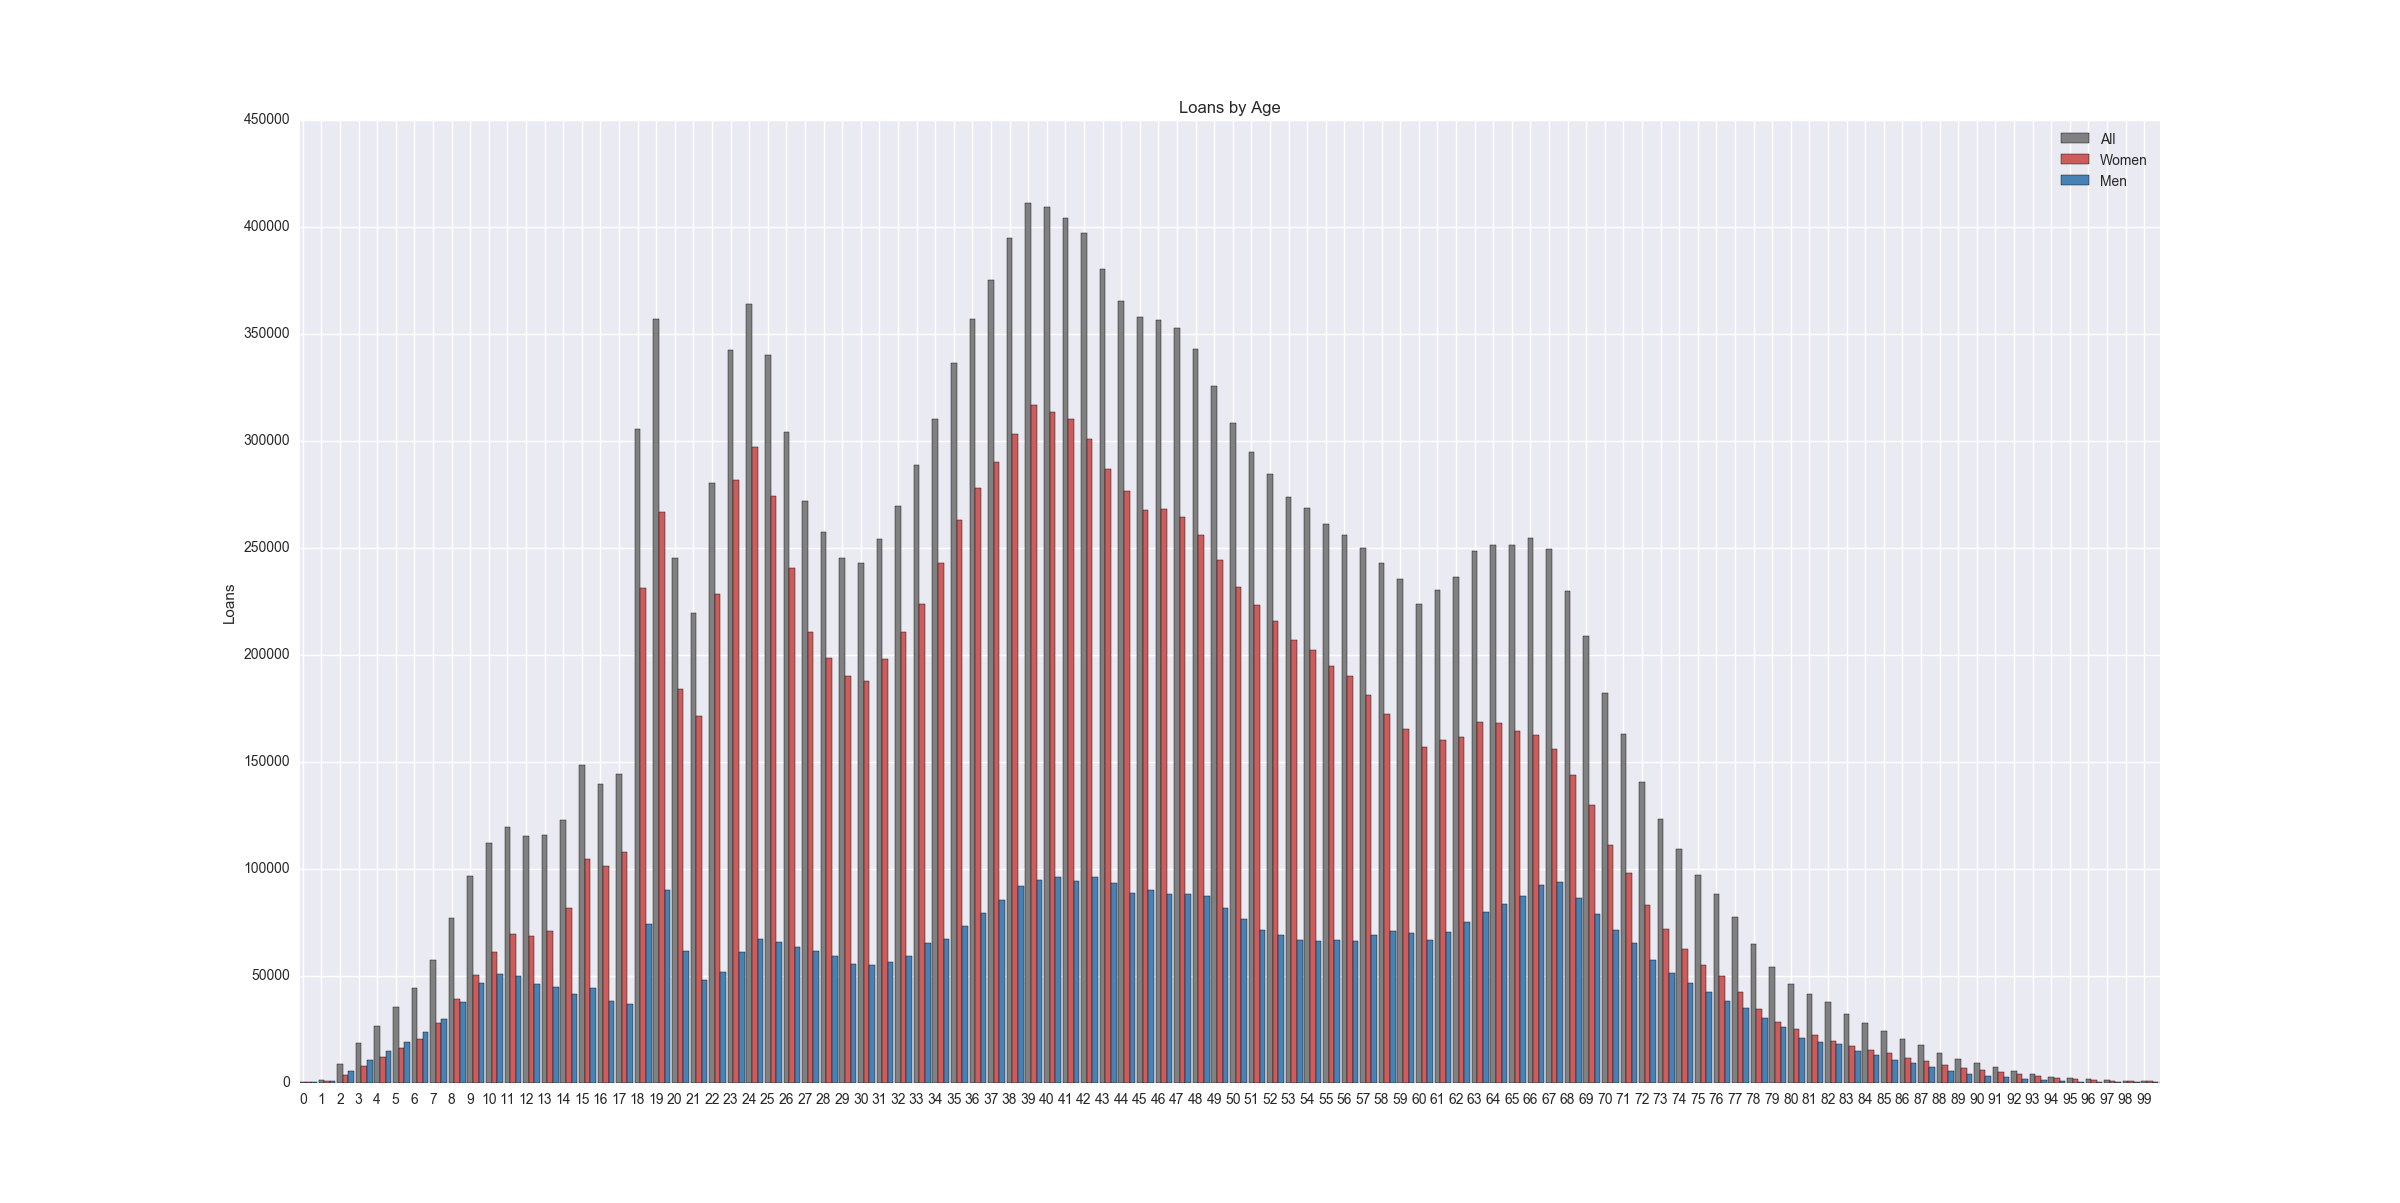

In [40]:
from IPython.display import Image
fig = Image(filename=('loan by age and gender.png'))
fig

### Noone reads your book!
The above image shows how many times each unique title has been loaned. An impressive amount 1.1 mio titles from our book database of 9 mio has never been loaned. The graph does however not take the no. of copies of each title, hence it is very likely that there are only very few of the titles that has been lent out 0 times. On the contrary there are several hundreds of other titles. Below we visualised the same graph, not counting 0's to get a better overview of the distribution of no. of loans per title.

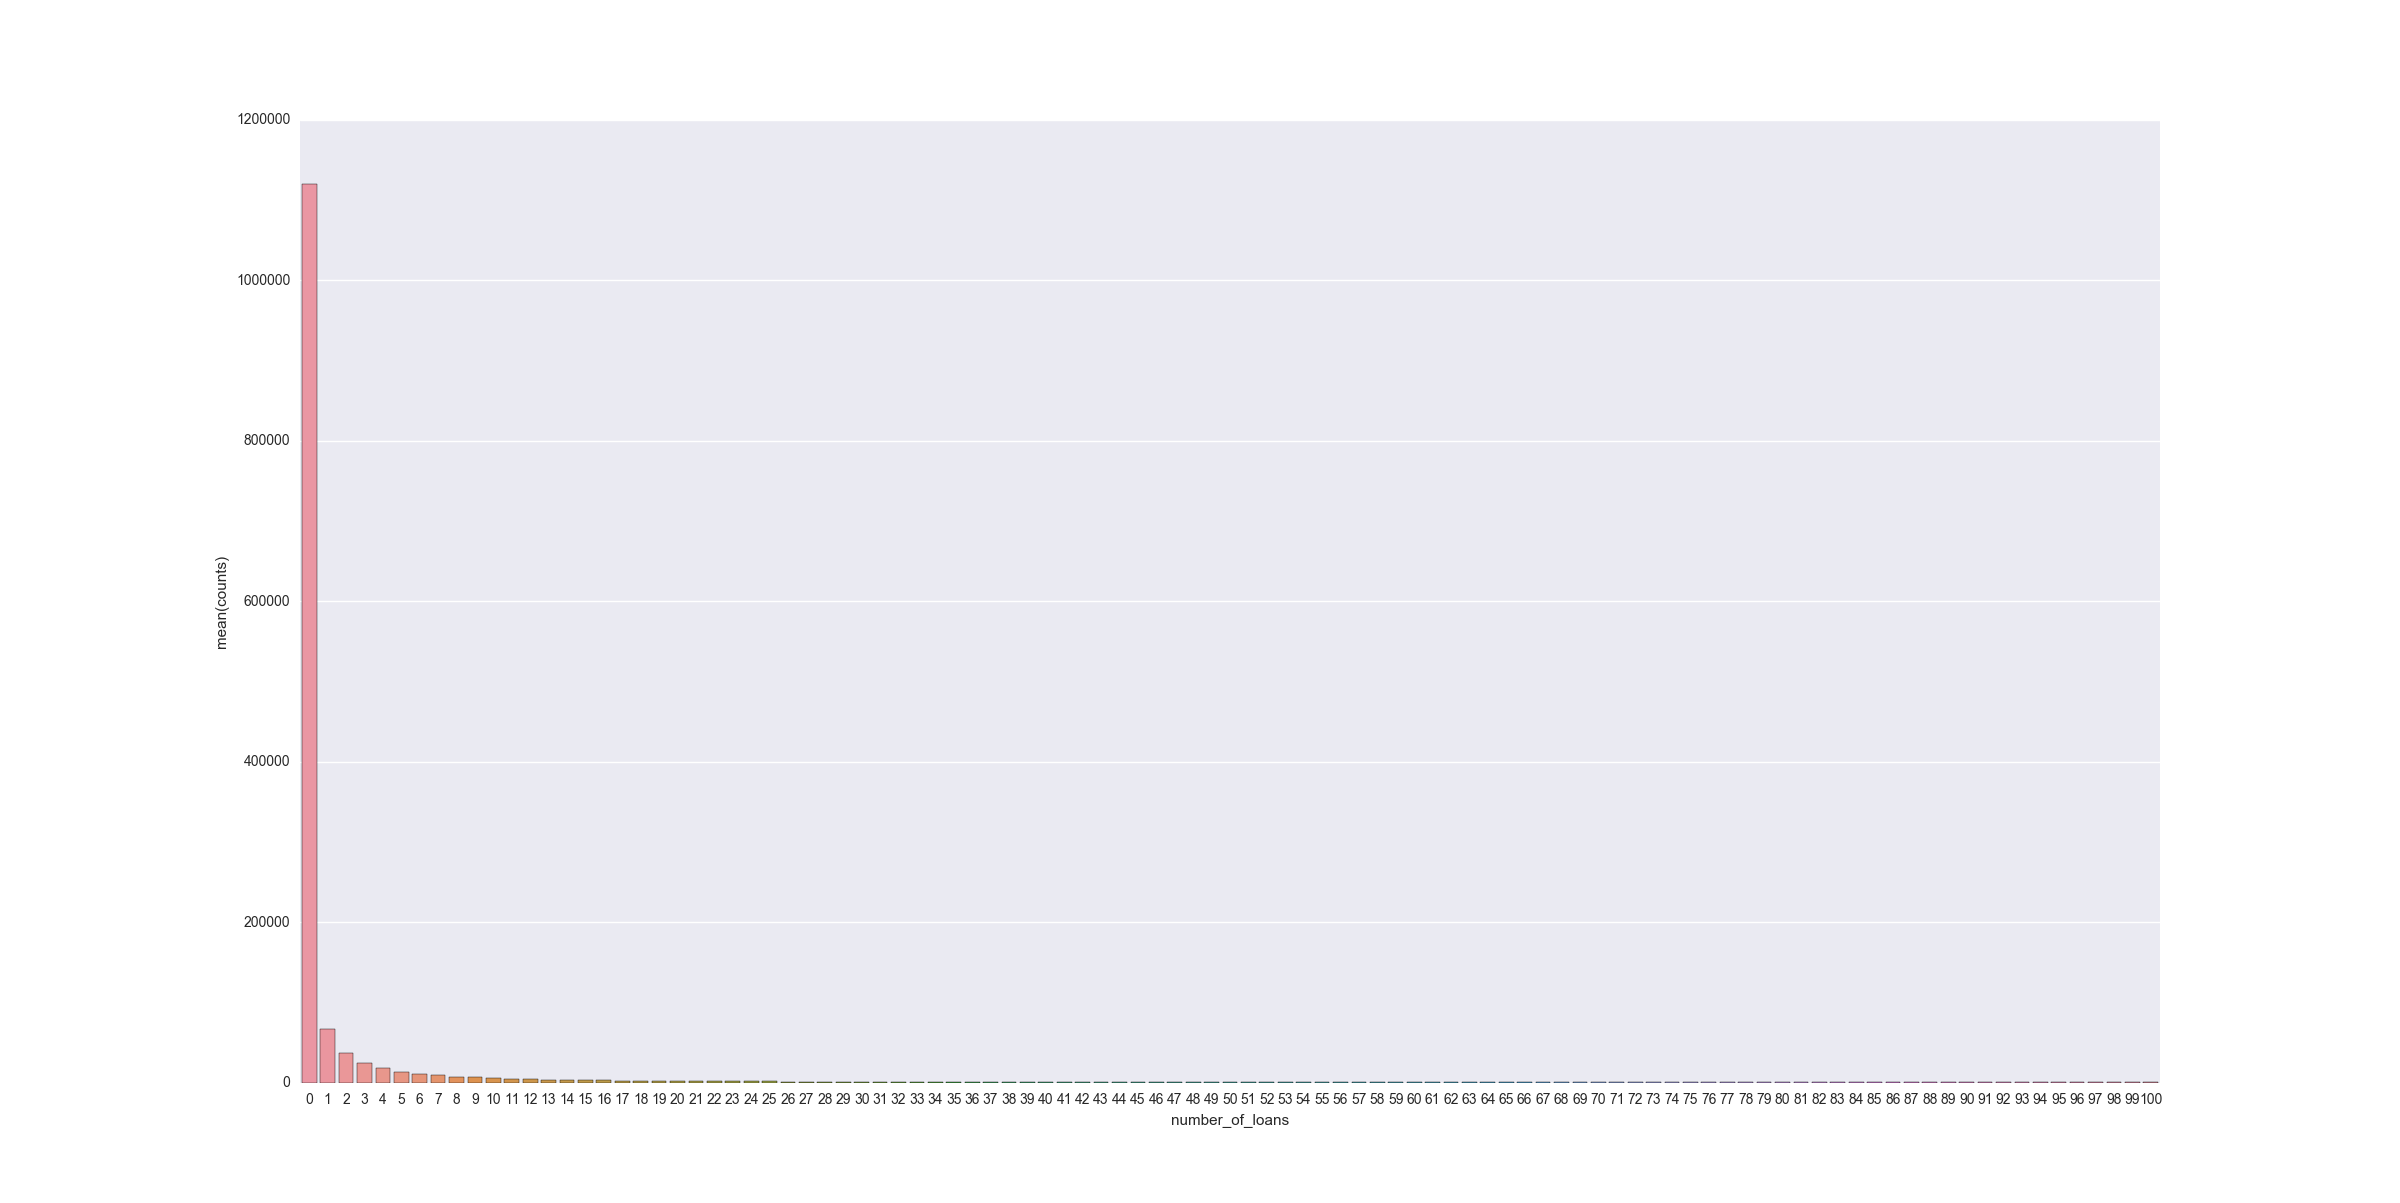

In [41]:
fig = Image(filename=('counts of how many times a book has been lent.png'))
fig

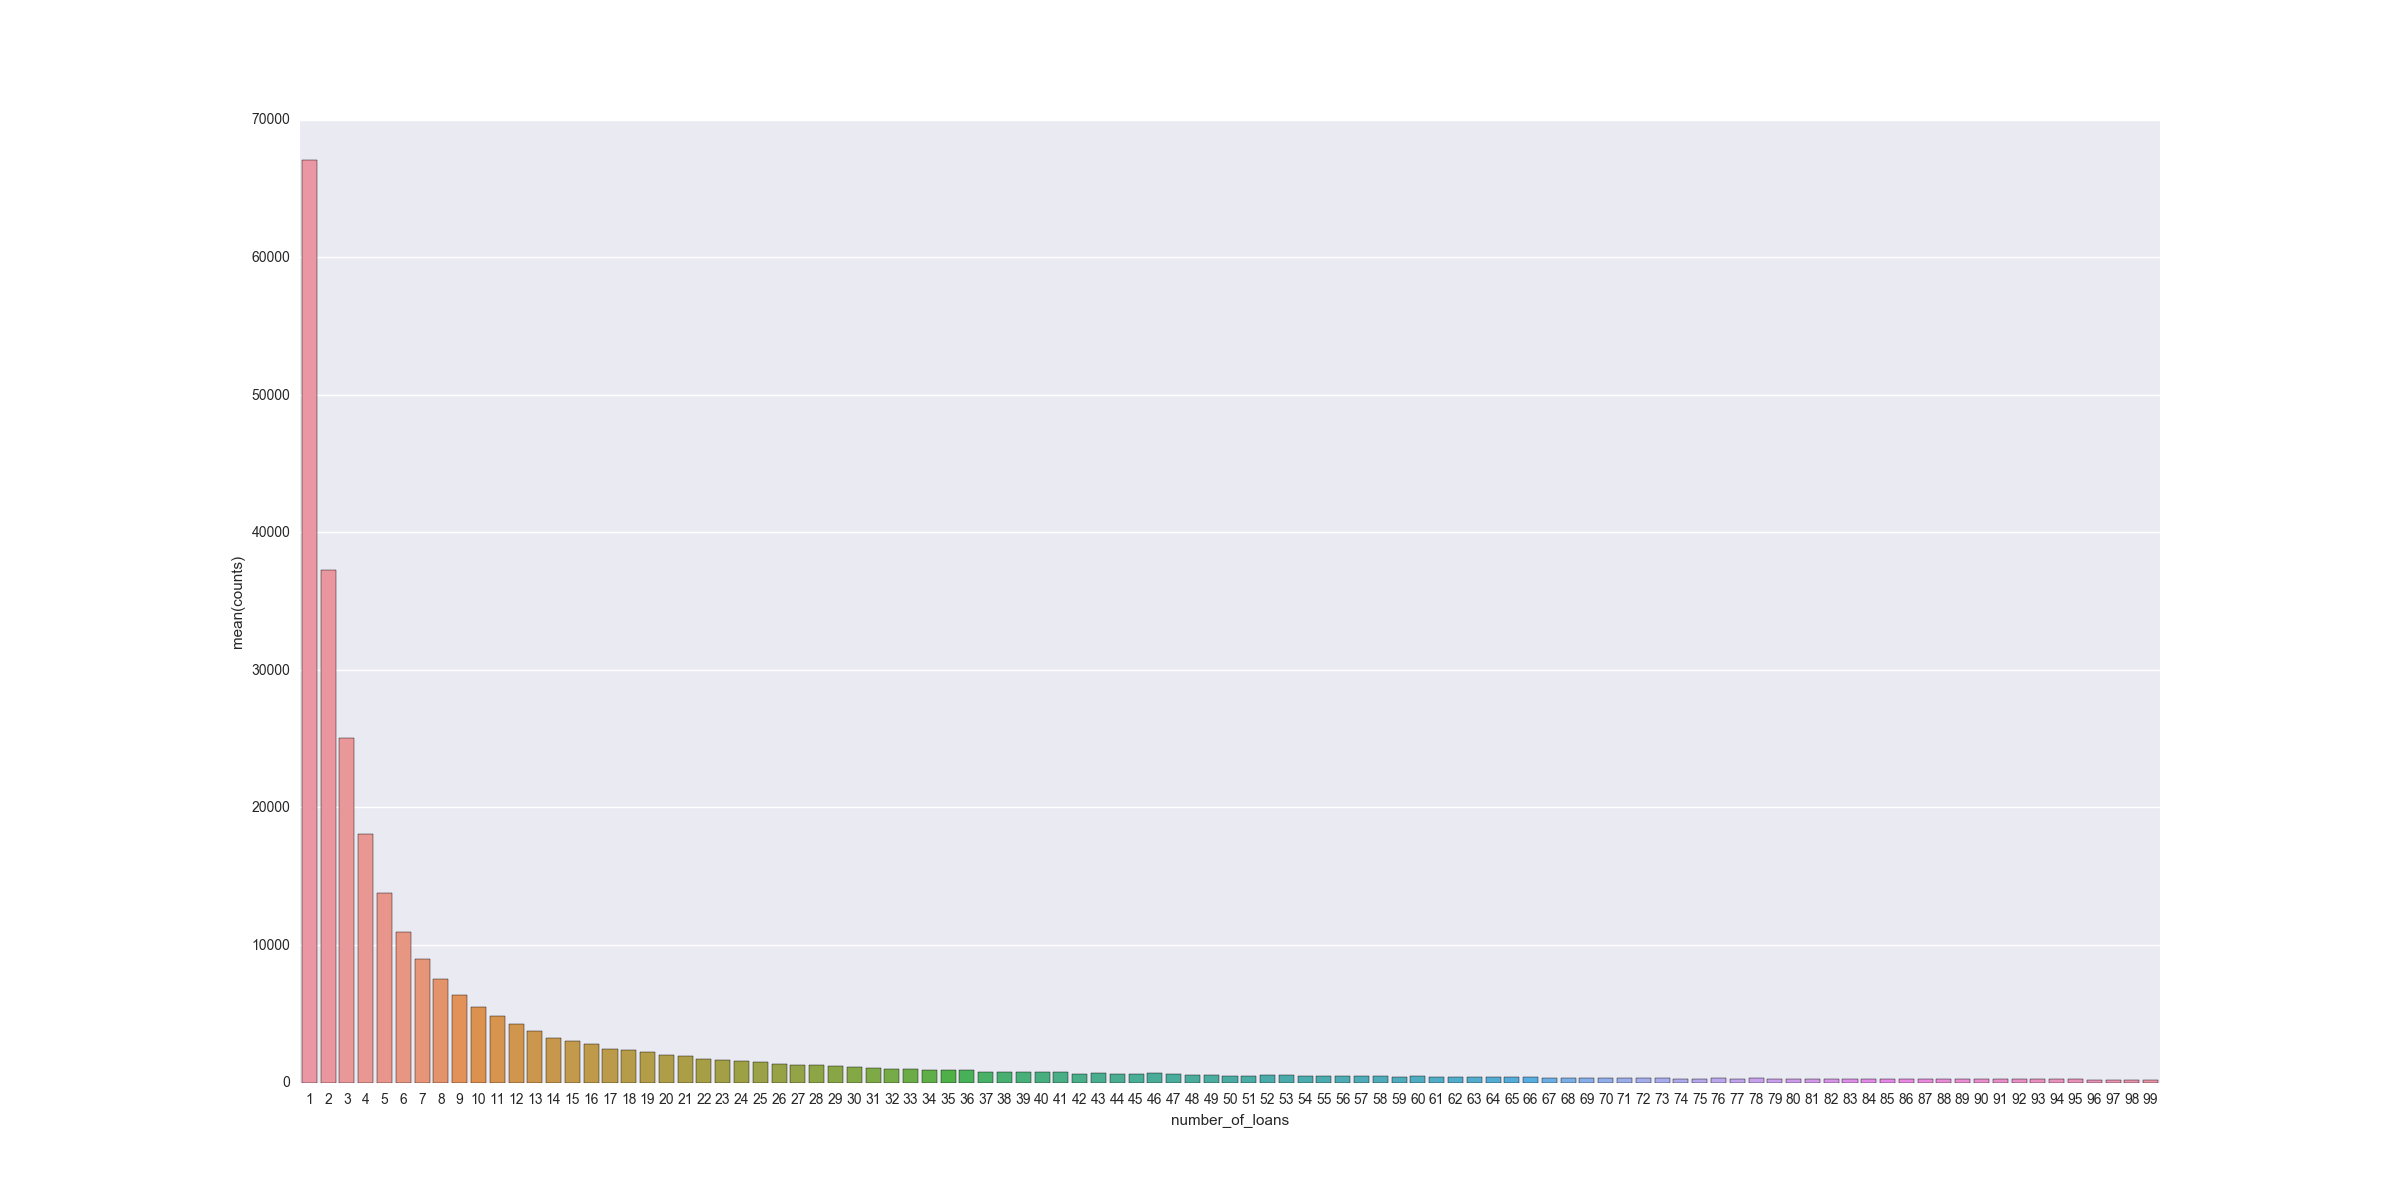

In [42]:
fig = Image(filename=('counts of how many times a book has been lent - not counting 0.png'))
fig

### Dk5 genre distribution
Visualing the genre distribution. At first glance the slightly unusual category of "hjem og husholdning" ranks 2. highest. As it turns out, this category includes diet books. The top book is "spis dig slank".. please...

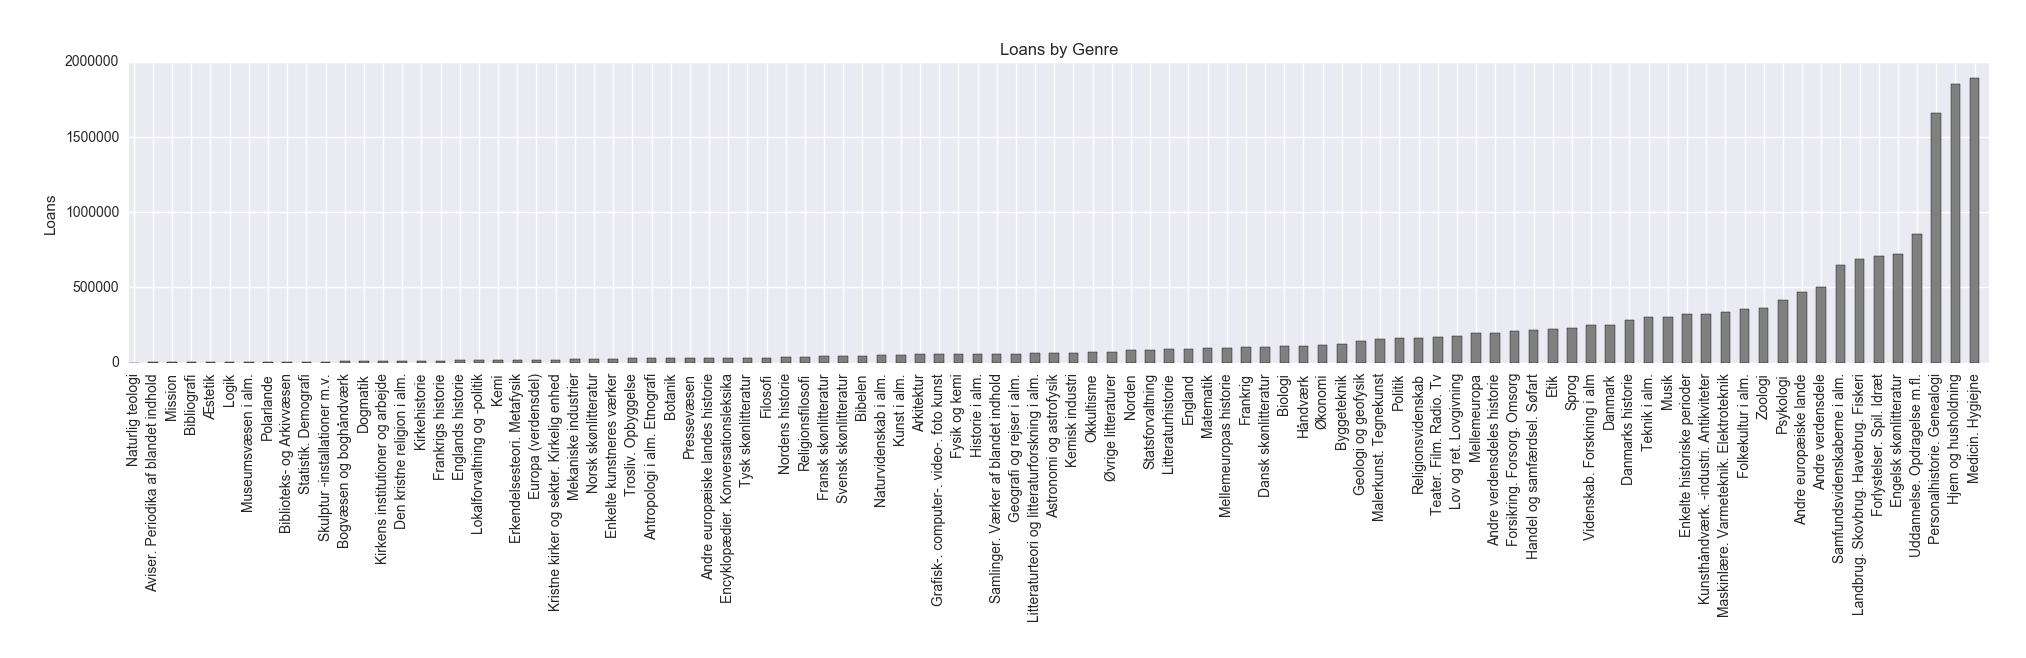

In [43]:
fig = Image(filename=('loans by genre.png'))
fig

### Loans per library
Visualing the no of loans at each library in our dataset. Not so suprisingly the majority of loans are from Copenhagen main library. The vis also reveals that the dataset only consists of a limited amount of libraries, for some reason no libraries form funen are f.x. included.

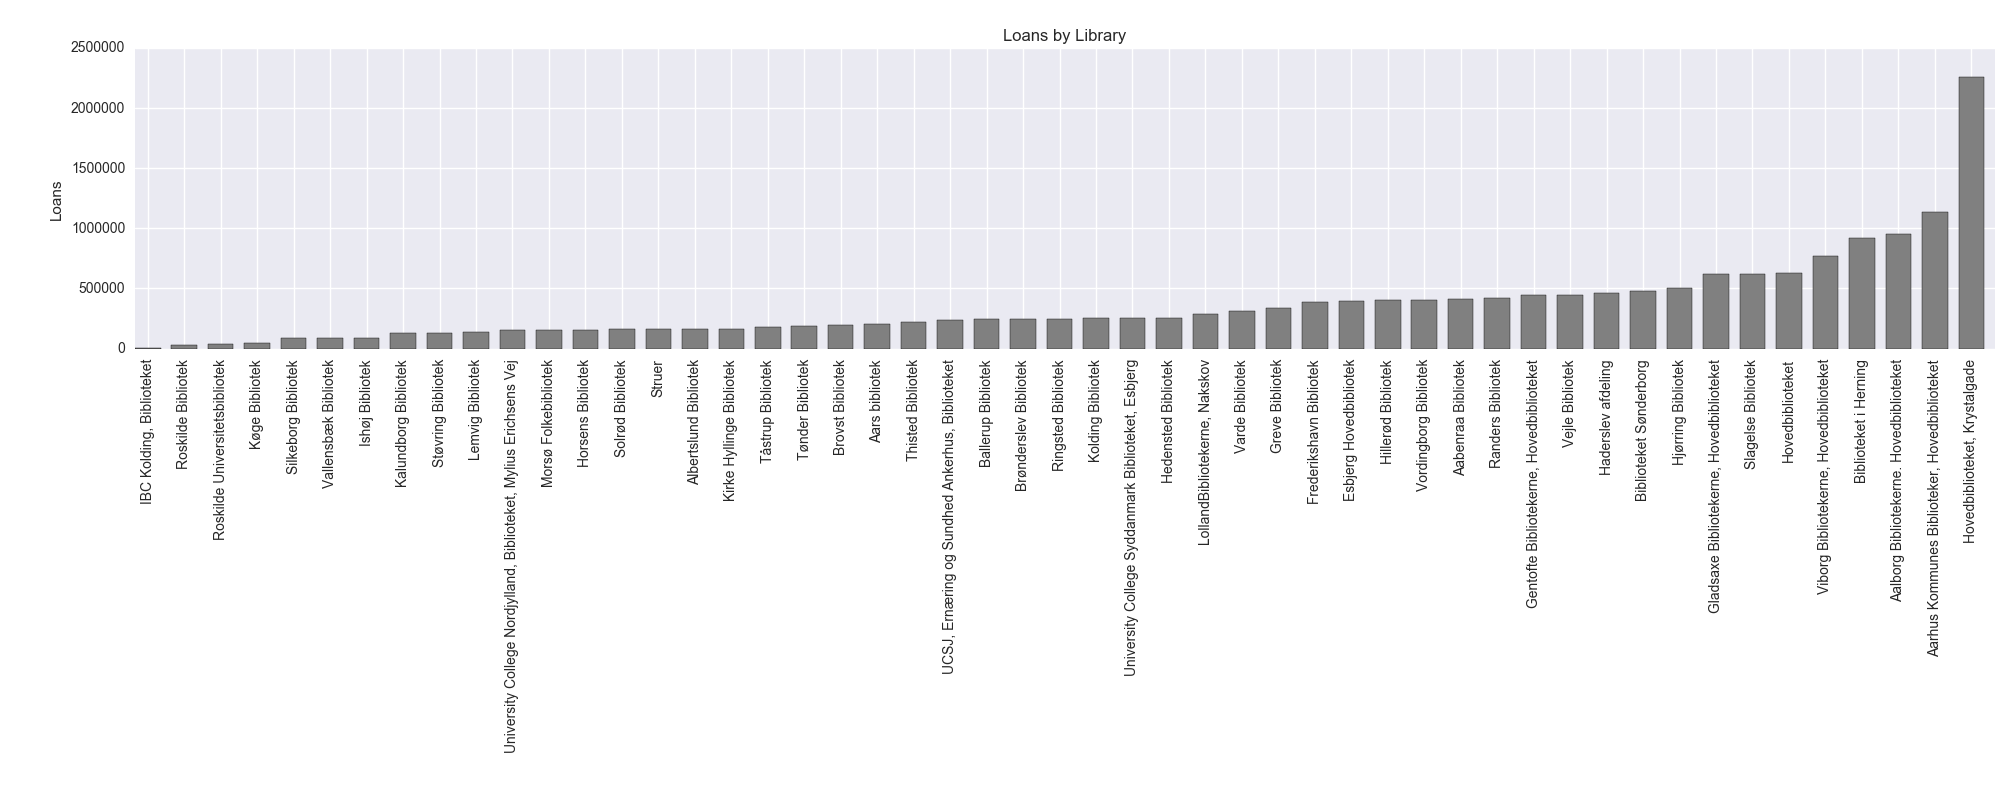

In [44]:
 fig = Image(filename=('loans by library.png'))
fig

### 50 shades..
Who is lending this wonderfull book? And where do they live!

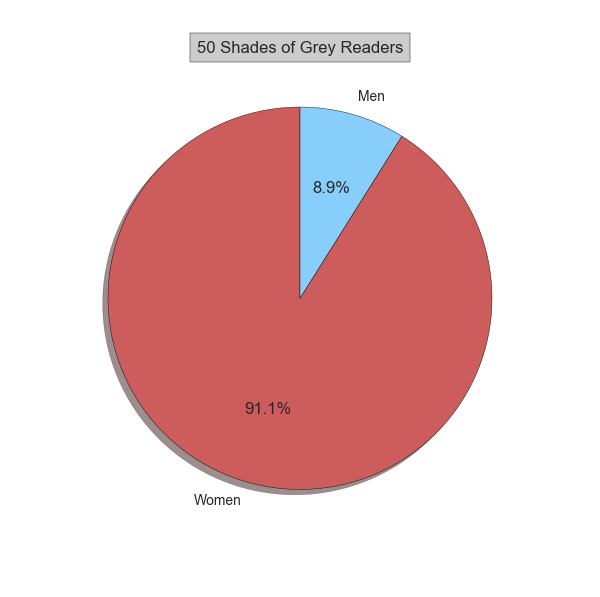

In [45]:
fig = Image(filename=('50 shades readers.png'))
fig

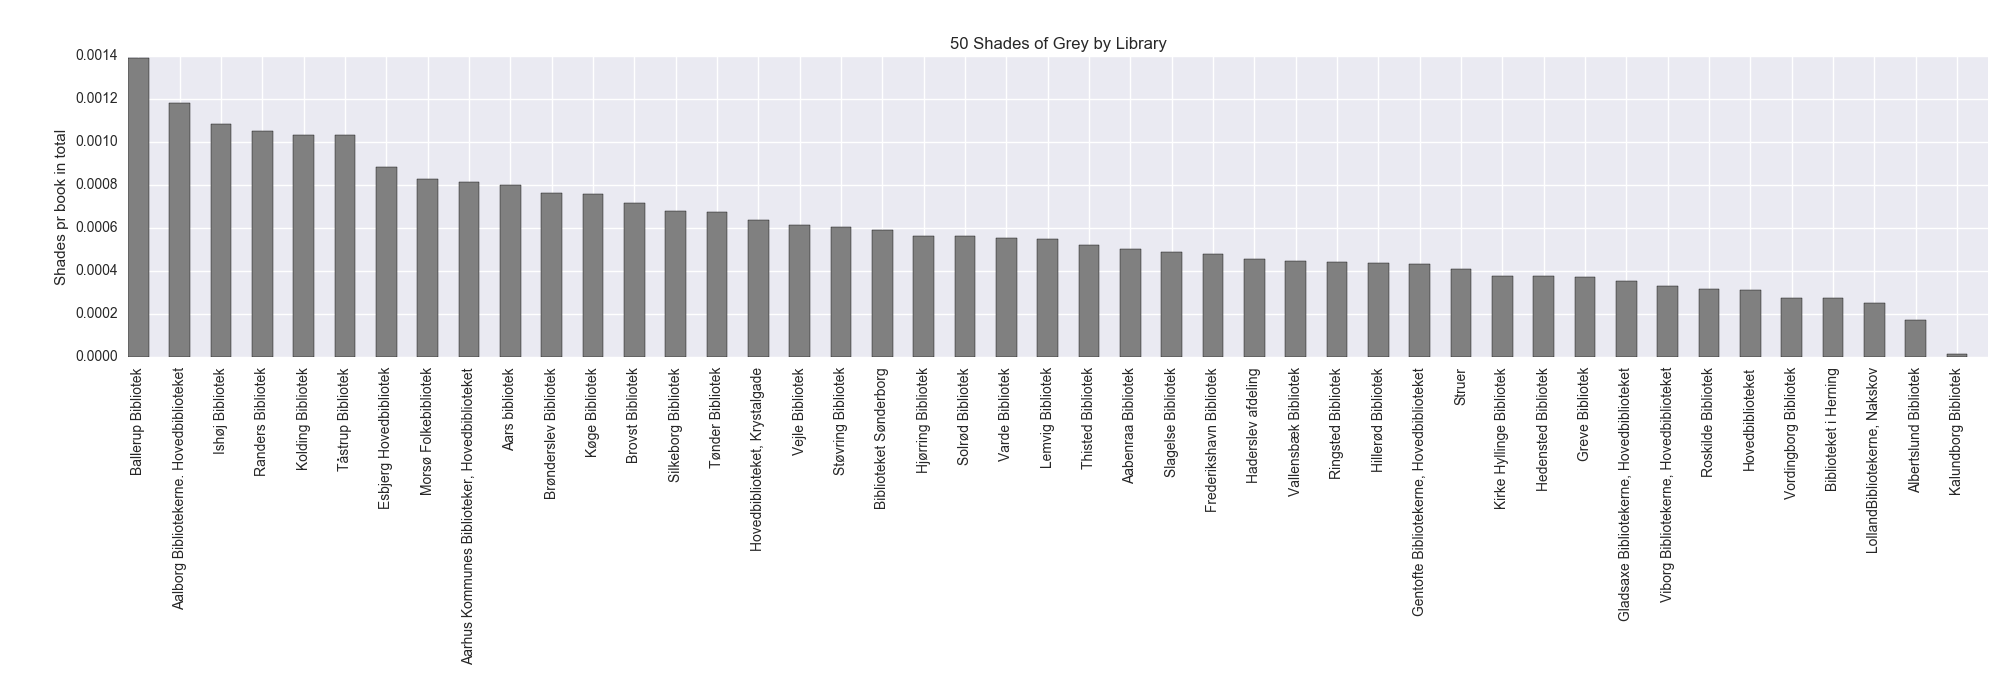

In [46]:
fig2 = Image(filename=('50 shades.png'))
fig2

Relative to the total no. of loans from that library. Damn you Ballerup. 

<a id="cell14"></a>
<a id="cell15"></a>

# A map of municipalities [d3]

## Why a map
Having looked solely at the distribution of loans according to titles, age and gender variations, we wanted to visualise regional differences of more general topics. Our idea was that there might be differences in the genres that people from different municipalities prefer. As a library, this potential regional difference may help the libarian select the best books to purchase based upon the location of the library.

We had our csv file containing each loan from 2009-2016 with a registrered book ID and library ID for each loan. Seperatly we then had 1 csv in which the book ID was matched with a DK5 number (the genre ordering system of Danish libraries) and another csv where the library ID was linked up with a postnummer and a lat/lon of the library. 

Our idea was then to draw a map of all the municipalities in Denmark in D3 & geojson. With python we would then create a dataframe containing the genre distribution of each municipality, relative to the total amount of rented books in that area. 

<a id="cell16"></a>

## Step 1: Cleaning loaner age and DK5 columns
Though this has somewhat already been done in our initial processing, the job of processing the data had been distributed hence it has been done slightly different for this part. The starting point is edited csv file which had initially been barbed down to only include the loans with dk5 titles.

In [47]:
df = pd.read_csv("giantdataset.csv") 

In [48]:
#Drop the columns we dont expect to use
df.drop(['Unnamed: 0','laaner_id','materiale_id'],inplace=True,axis=1)

In [49]:
df.head() 

,biblioteks_id,koen,foedselsaar,dato,dk5
0,830060,k,1994-01-01,2015-03-05,"[61.45,66.8]"
1,830060,m,1988-01-01,2015-03-12,"[61.45,66.8]"
2,830060,k,1992-01-01,2015-03-05,"[61.45,66.8]"
3,757300,k,1992-01-01,2015-03-13,"[61.45,66.8]"
4,830060,k,1985-01-01,2015-01-28,"[61.45,66.8]"


In [50]:
unique_lib = df.biblioteks_id.unique()
print len(unique_lib)
print df.shape

53
(18491051, 5)


Having chopped off all the registrered loans that does not contain dk5 numbers and of which the library ID doesn't match our list, we have now ended up with ~ 18.5 mio. loans. These are apparently only registered at 53 different libraries. 

### Figuring out the age of the lonaer at the time of loan and shorting down dk5 to it's primary categories

In [51]:
#Delete month and day of both birth year and lend date, we are only interested in the age of loaner
df['foedselsaar'] = df['foedselsaar'].str[:4]
df['foedselsaar'] = df['foedselsaar'].astype('float64')
df['dato'] = df['dato'].str[:4]
df['dato'] = df['dato'].astype('float64')

# Substracts year of birth from year of lend to get age of loaner. Minor error since a person born 24/11/1991 
# borrowing a book 1/1/2016 would be considered 25 despite the person only being 24... 
df['age'] = df['dato'].sub(df['foedselsaar'], axis=0)

In [52]:
#As seen we have some faulty data as a loaner is apparently -18 years old. Max of 101 seems plausible.
df['age'].describe()

count    18309946.000000
mean           42.680716
std            18.196338
min           -18.000000
25%            28.000000
50%            42.000000
75%            56.000000
max           101.000000
Name: age, dtype: float64

In [53]:
#Hence we delete all rows with ages below 0
df = df[df.age >= 0]

In [54]:
#For further editing we create a copy of our dataframe
df_short = df.copy()
#We no longer need the birth year nor year of loan
df_short.drop(['foedselsaar', 'dato'],inplace=True,axis=1)

In [55]:
#Now we need to sort out the DK5 tag
#As it turns out around 5000 registered loans contains a DK5 tag "NY TITEL", some of them also a DK5 no., some not.
df_short['dk5'] = df_short['dk5'].str.replace('"NY TITEL"', '')

In [56]:
#Next off we remove everything to the right of the dot "." which seperates the top categories with sub categories
df_short['dk5'] = df_short['dk5'].apply(lambda x: x.split('.')[0])
#Lastly the front branket is removed,
df_short['dk5'] = df_short['dk5'].map(lambda x: x.lstrip('['))
#And finally the strings are converted to numeric values,
df_short['dk5'] = df_short['dk5'].convert_objects(convert_numeric=True)

C:\Users\Jonatan\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


In [57]:
df_short['dk5'].describe()
#As the DK5 system ranges from 0-99 it seems as if we've now sorted the column sufficiently. 

count    18262111.000000
mean           61.154697
std            23.524422
min             0.000000
25%            45.000000
50%            62.000000
75%            79.000000
max            99.000000
Name: dk5, dtype: float64

In [58]:
#This file is saved as CSV and processed further in another ipython. 
#For the sake of the explainer notebook everything has been put together, and the below line commented out.
#df_short.to_csv('lib_sex_dk5_age.csv',index=False)

<a id="cell17"></a>

## Step 2 : Matching with postnummer
Now that we have a file containing the genre of each loan and a library ID the next step is to match this library ID with a specific postnummer, so that we can distrubute these loans accordingly to each kommune.

In [59]:
df_dk5 = pd.read_csv("lib_sex_dk5_age.csv")

In [60]:
#The library csv is downloaded directly from hack4dk,
#Index col false is added as Pandas mistakenly interprets biblioteks ID as the index
df_lib = pd.read_csv("libraries.csv", index_col=False)

In [61]:
df_lib.head()

,biblioteks_id,navn,væsensnavn,adresse,postnummer,by,bibliotekstype
0,700400,Flensborg Bibliotek,Dansk Centralbibliotek for Sydslesvig e.V.,Norderstrasse 59,D-24939,Flensburg,Folkebibliotek
1,700401,Husum Bibliotek,Dansk Centralbibliotek for Sydslesvig e.V.,Neustadt 81,D-25813,Husum,Folkebibliotek
2,700402,Slesvig Bibliotek,Dansk Centralbibliotek for Sydslesvig e.V.,Bismarckstraße 18A,D-24837,Schleswig,Folkebibliotek
3,700404,Fællesbiblioteket Egernførde,Dansk Centralbibliotek for Sydslesvig e.V.,Hans-Chr-Andersen Weg 2,D-24340,Eckernförde,Folkebibliotek
4,700405,Bogbusserne,Dansk Centralbibliotek for Sydslesvig e.V.,Norderstr. 59,D-24939,Flensburg,Folkebibliotek


In [62]:
#Drop the columns we dont expect to use
df_lib.drop(['væsensnavn','bibliotekstype','navn'],inplace=True,axis=1)

#All we need is to match library ID from out DK5 df with a library ID from our lib csv,
#so that we can add a postnummer to each loan.

# Merge on "inner" to avoid NaN values. Only exact matches are transfered.
df2 = pd.merge(df_dk5, df_lib, how='inner', on=['biblioteks_id'])

In [63]:
#If s1 = pd.merge(df_dk5, df_lib, how='left', on=['biblioteks_id']) it is shown that s1['navn'].isnull().sum() = ~ 300.000
#Hence for some reason loads of loans are registrered at a library ID which is not to be found in our library csv file...
#rather strange and quite a large chunch of our 1.8 mio. total loans. 

unique_lib2 = df2.biblioteks_id.unique()
print len(unique_lib2)
#As seen 2 of the previous 53 libraries have been "lost" in our merge. We checked these values manually, they were indeed not
#to be found in the lib csv, and it wasn't possible to find a library ID close to the missing (i.e. if caused by a typo).

51


In [64]:
df2.head()

,biblioteks_id,koen,dk5,age,adresse,postnummer,by
0,757300,k,61,23,Rådhusstræde 2,6800,Varde
1,757300,k,61,24,Rådhusstræde 2,6800,Varde
2,757300,k,61,22,Rådhusstræde 2,6800,Varde
3,757300,k,61,17,Rådhusstræde 2,6800,Varde
4,757300,k,61,33,Rådhusstræde 2,6800,Varde


In [65]:
#Saves the postnummer as a int
df2['postnummer'] = df2['postnummer'].convert_objects(convert_numeric=True)
#Removes the last unesc. columns
df2.drop(['biblioteks_id','by'],inplace=True,axis=1)
df2.head()

C:\Users\Jonatan\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  from ipykernel import kernelapp as app


,koen,dk5,age,adresse,postnummer
0,k,61,23,Rådhusstræde 2,6800
1,k,61,24,Rådhusstræde 2,6800
2,k,61,22,Rådhusstræde 2,6800
3,k,61,17,Rådhusstræde 2,6800
4,k,61,33,Rådhusstræde 2,6800


In [66]:
#This file is saved as CSV and processed further in another ipython. 
#For the sake of the explainer notebook everything has been put together, and the below line commented out.
#df2.to_csv('sex_dk5_age_adress_post.csv',index=False)

<a id="cell18"></a>

## Step 3: Matching postnummer with kommune
Since postnumre is often very small geographic entities, we needed to merge these with the overlying kommune so that our d3 map would be easy to get an overview of.

When trying to merge the loan dataset, now containing a postnummer, with a list of postnumre in relation to municipalities, it turned out that a postnummer is not nescesarily unique to a specific municipality. Hence 1 book loan with a specific postnummer matched 2,3,4 or even 5 different municipalities which twisted our data from ~19 mil rows to ~29 mil, a too huge error margin to ignore. As the original loan dataset only contained a postnummer and adress of a specific library, we will have to manually look up whether there are indeed several libraries sharing the same postnummer, and if not, to which municipality the specific postnummer does belong to in our dataset... Another option would have been to have made some sort of google maps API that googled the adresses and returned the postnummer but it seemed like an even more time consuming task after ascessing the amount of postnummre which was duplicates.

In [67]:
#From Post Danmark we found a CSV containing each postnummer along with a range of different info in relation,
df_kom = pd.read_csv("kommunepost.csv")
df_kom.head()

,REGIONS_NR,ADRESSERINGSNAVN,KOMMUNE_NR,ADRESSERINGSNAVN_1,POSTNR,BYNAVN
0,1084,Region Hovedstaden,169,H�je-Taastrup Kommune,800,H�je Taastrup
1,1084,Region Hovedstaden,101,K�benhavns Kommune,900,K�benhavn C
2,1084,Region Hovedstaden,153,Br�ndby Kommune,917,K�benhavns Pakkecent
3,1084,Region Hovedstaden,101,K�benhavns Kommune,960,Udland
4,1084,Region Hovedstaden,101,K�benhavns Kommune,999,K�benhavn C


In [68]:
#Drop the columns we dont expect to use from the kommune csv
df_kom.drop(['REGIONS_NR','KOMMUNE_NR','ADRESSERINGSNAVN'],inplace=True,axis=1)
#Load the previously saved csv containing dk5 and postnummer
df_loan = pd.read_csv("sex_dk5_age_adress_post.csv")

In [69]:
#Renaming the postnummer column to do merge
df_loan.rename(columns={'postnummer': 'POSTNR'}, inplace=True)

In [70]:
#First off we make a list of the postnummers that we are interested in, i.e. those who have registrered loans within
unique_loan = df_loan.POSTNR.unique()
unique_loan = pd.Series(unique_loan) #Transform to pandas series
len(unique_loan)
#A total of 49 unique postnummer in our loan database

49

In [71]:
#Next up we create a list of every postnummer in Denmark that belongs to more than 1 kommune
count_kom = df_kom.POSTNR.value_counts()
count_kom = count_kom[count_kom > 1]
len(count_kom)
#A total of 238 postnumbers.

238

In [72]:
#Finally we match these two lists to see which postnumbers we will have to check manually in our database.

#To do so we create a new pandas dataframe with the postnummer as a column
count_kom = DataFrame(count_kom)
count_kom.columns = ['count']
count_kom['postnummer'] = count_kom.index

#And checks whick ponstnumbers from our loans are ambigous
count_sum = count_kom[count_kom['postnummer'].isin(unique_loan)]
len(count_sum)

21

In [73]:
#Hence we have 21 postnumbers that we shall manually check to verify in which kommune the library is in fact located
count_sum

,count,postnummer
4100,6,4100
4200,4,4200
7600,3,7600
7400,3,7400
8600,3,8600
4000,3,4000
2750,3,2750
3400,3,3400
4180,3,4180
7100,2,7100


Manually we then looked up every postnummer in the library csv file, read the name and specific adress of the library, and acessed whether there was ever more than 1 library with the same postnummer, and if not, which kommune this specific library did in fact belong to. Luckily there was only 1 library in each postnummer on all ocasions.

4100 : Køge, Holdbæk, Faxe, Ringsted, Sorø or Næstved. Only 1 library in Ringsted with that postnummer.

4200 : Kalundborg, Slagelse, Sorø, Næstved. Only 1 library in Slagelse. 

7600 : Holsebro, Lemvig, Struer. Only 1 lib in 7600, Struer Folkebibliotek.

7400 : Could be either ikast-brande, ringkjøbing-skjern or herning. Several locations, but only libraries located in Herning.

8600 : Silkeborg, Skanderborg or Ikast-brande. Only 2 in Silkeborg registrered in that postnummer.

4000 : Høje taastrup, Roskilde or Lejre. Several libraries located in Roskilde (RUC + public) .

2750 : Alberslund, Egedal or Ballerup. Only 1 library in Ballerup.

3400 : Hillerød, Allerød, Fredensborg. Only 1 lib in Hillerød.

4180 : Sorø, Ringsted or Slagelse. Only 1 in Sorø.

7100: Vejle or Hedensten. A Research library in Vejle non in hedensten.

2860: Copenagen og Gladsaxe. Only gladsaxe library.

2900: Gentofte or Copenhagen. In 2900 gentofte main library is located along with Dyssegaard library. Both placed in Gentofte-

9700 : Brønderslev or Jammerbugten. Only lib in Brønderslev.

9600 : Vesthimmerland or Rebild. Only lib in Vesthimmerland, 

9530 : Rebild or Aalborg. Lib in rebild.

8800 : Silbeborg or Viborg. Only a library in Viborg with that postnummer. 

4600 : Køge or Stevns. Only 1 lib in kØge on this.

8700 : Horsens or Hedensted. Research lib in horsens non in hedensten.

9900 : Frederikshavn or Hjørring. Only 1 in frederikshavn.

2620 : Brøndby or Albertslund . Only 1 in Albertslund.

6100 : Kolding or Haderslev. Only 1 in Haderslev.


In [74]:
#The manually edited postnummer file is loaded in,
df_kom_edited = pd.read_csv("kommunepost_edited.csv")
#Drop the columns we dont expect to use from the kommune csv
df_kom_edited.drop(['REGIONS_NR','KOMMUNE_NR','ADRESSERINGSNAVN'],inplace=True,axis=1)

In [75]:
print len(df_kom)
print len(df_kom_edited)
#Hence 35 ambigious postnummer/kommune relations had now been deleted

1418
1383


In [76]:
#Now merging postnummer and kommune
df = pd.merge(df_loan, df_kom_edited, how='inner', on='POSTNR')
#And removing columns
df.drop(['adresse','POSTNR','BYNAVN'],inplace=True,axis=1)

In [77]:
df.head()

,koen,dk5,age,ADRESSERINGSNAVN_1
0,k,61,23,Varde Kommune
1,k,61,24,Varde Kommune
2,k,61,22,Varde Kommune
3,k,61,17,Varde Kommune
4,k,61,33,Varde Kommune


In [78]:
unique_kom = df.ADRESSERINGSNAVN_1.unique()
unique_kom = pd.Series(unique_kom) #Transform to pandas series
len(unique_kom)
#As we only had 49 library ID's it is no wonder that we now only have data for a similar amount (in fact 2 smaller) of kommuner.
#This means that many parts of our D3 kommune map will be empty.

47

<a id="cell19"></a>

## Step 4: Relative dk5 distribution of each kommune
Next step was to look at the relative distribution of genre loans in each kommune, the data that we would plot in our d3 visualisation.

We have decided not to look at the 100 subcategories of the Dk5 system, but rather just the 10 large main categories.
The dk5 system is ordered so that 0-9 is a main category, and each of these 0,1,2,3 etc. represent a sub category. The main category can then simply be found by buckting our Dk5 accordingly: 0-9 = 0, 10-19 = 1, 20-29 = 2 etc.

In [79]:
from __future__ import division
df['dk5'] = [int(x / 10) if (x > 9) else 0 for x in df.dk5]

In [80]:
df_total = df.groupby(["ADRESSERINGSNAVN_1", "dk5"]).size().reset_index(name="No of loans")
df_total.head()

,ADRESSERINGSNAVN_1,dk5,No of loans
0,Aabenraa Kommune,0,3831
1,Aabenraa Kommune,1,22168
2,Aabenraa Kommune,2,6660
3,Aabenraa Kommune,3,44819
4,Aabenraa Kommune,4,37245


In [81]:
#We flip the axis of the above through a pivot table (i.e. instea of dk5 as 1 column we split into a column for each category)
df_total_trans = df_total.pivot_table('No of loans', ['ADRESSERINGSNAVN_1'], 'dk5')
df_total_trans.columns = np.arange(0,10)       

In [82]:
#The relative loan of each genre is calculated based upon the sum of loans in each kommune
for index,row in df_total_trans.iterrows():
    rowsum = sum(row)
    count = 0
    while count < 10:
        df_total_trans[count].loc[index] = row[count] / rowsum
        count = count + 1

In [83]:
#Header renamed
df_total_trans = df_total_trans.rename(columns={0: 'Kommune'})


#Dk 5 columns are as of now just 0,1,2, - the below csv contains their name matched with these numbers
df_dk5 = pd.read_csv("dk5.csv")

df_total_trans.columns=df_dk5[" Kategori"]
df_total_trans.index.name = 'Kommune'
df_total_trans.columns.name = 'DK5 Kategori'

df_total_trans.head()

DK5 Kategori,Bogvæsen og boghåndværk,Filosofi,Den kristne religion,Samfundsvidenskaberne,Geografi og rejser,Naturvidenskab,Teknik,Kunst,Litteraturteori og litteraturforskning,Historie
Kommune,,,,,,,,,,
Aabenraa Kommune,0.009452,0.054694,0.016432,0.110579,0.091892,0.053250,0.330692,0.110853,0.050324,0.171831
Aalborg Kommune,0.008750,0.070373,0.012915,0.182515,0.086266,0.038726,0.323546,0.092629,0.061348,0.122932
Aarhus Kommune,0.010972,0.062809,0.019095,0.127708,0.103181,0.051158,0.304887,0.095303,0.084720,0.140167
Albertslund Kommune,0.011369,0.057304,0.019975,0.126432,0.104615,0.069827,0.252667,0.100883,0.103142,0.153786
Ballerup Kommune,0.008237,0.049200,0.013001,0.114093,0.120671,0.072756,0.275552,0.096862,0.100348,0.149280


In [84]:
#This is the file used for our d3 map of the kommuner,
#Saved as CSV 
#df_total_trans.to_csv('kommune_ratio.csv',index=True)

<a id="cell20"></a>
<a id="cell21"></a>

# Denmark map [KNN]

## Why KNN
Having done the d3 map of distributions, it was quite obvious that our dataset lacked substantial loan data from municipalities across Denmark. For some reason,even the original dataset, doesn't contain any loan data from Funen and several other regions of Denmark.

To try and map our data across all of Denmark we got the idea of using a knn algorythim a bit creatively...

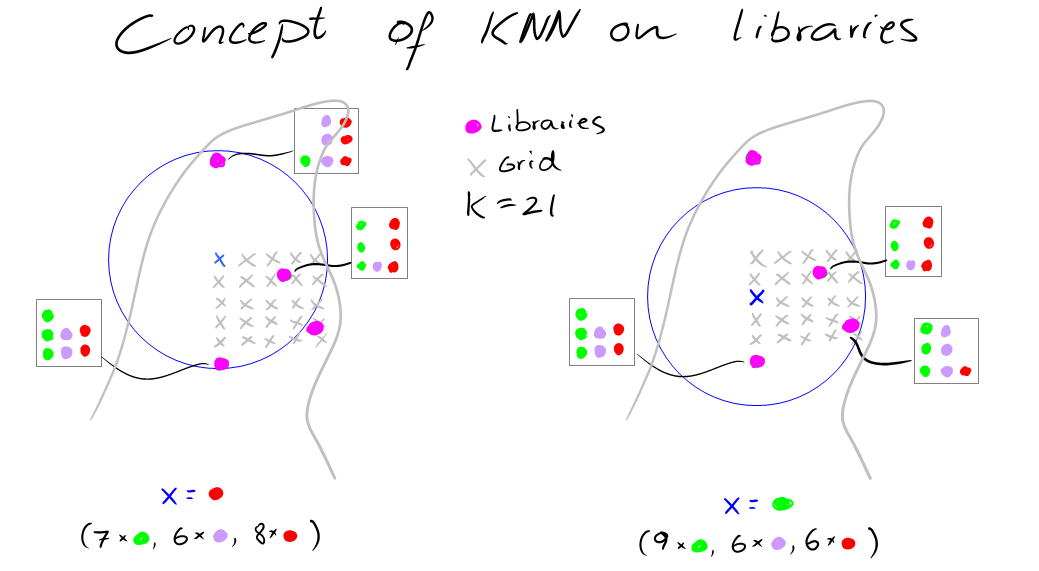

In [85]:
from IPython.display import Image
fig = Image(filename=('knn_png.png'))
fig

Our idea was to find the relative distribution of genre loans from each library (defined by lon/lat). We would then transform the rounded % of the loans in each category into a number of points with that specific label - all placed at this library location. A library with 10% of its loans belonging to the history genre would generate 10 datapoints with label "History" and this specific lon/lat. Each library would then have 100 datapoints hence we would expect to train the algorithm with k = 100,200,300 etc. to include 1,2,3 or more libraries.

The concept is examplified in the above png in which we imagine that there are just 3 different labels (green, purple, red) and 27 datapoints per library (instead of 100). Having made a grid across Denmark, our initial point (blue cross) with k=27 would include the nearest 3 libraries. Summing up the loans of the nearest 27 neighboors, would lead to the point being classified as label red. As we move further in our grid, right side of the image, the nearest 27 neighboors now include another library with different label distributions. This point would hence be classified as green. 

As several of the municipalities in Denmark, as seen on our first map, didn't have any registrered loans, we figured that this would righfully represent these areas of Denmark. If there was a kommune without any library, it seemeed likely that a mixture of the 2,3,4 nearest libraries would represent the overall loaner preference of that area. 

<a id="cell22"></a>

## Step 1: Cleaning location data
The process is very similar to the one of merging loans with postnumbers and calculating the relative ratio of loans in each kommune

In [86]:
#As it turns out ~10 libraries had missing lon/lats (including DTU!), these was removed (non loans registrered anyway)
df_lib = pd.read_csv("libraries_lonlat.csv", index_col=False)

In [87]:
df_lib.head()

,biblioteks_id,navn,væsensnavn,adresse,postnummer,by,bibliotekstype,latlon
0,700400,Flensborg Bibliotek,Dansk Centralbibliotek for Sydslesvig e.V.,Norderstrasse 59,D-24939,Flensburg,Folkebibliotek,"{""lat"": 54.79212, ""lng"": 9.43103}"
1,700401,Husum Bibliotek,Dansk Centralbibliotek for Sydslesvig e.V.,Neustadt 81,D-25813,Husum,Folkebibliotek,"{""lat"": 54.4801716, ""lng"": 9.046711499999999}"
2,700402,Slesvig Bibliotek,Dansk Centralbibliotek for Sydslesvig e.V.,Bismarckstraße 18A,D-24837,Schleswig,Folkebibliotek,"{""lat"": 54.5188982, ""lng"": 9.5640843}"
3,700404,Fællesbiblioteket Egernførde,Dansk Centralbibliotek for Sydslesvig e.V.,Hans-Chr-Andersen Weg 2,D-24340,Eckernförde,Folkebibliotek,"{""lat"": 54.47328, ""lng"": 9.82871}"
4,700405,Bogbusserne,Dansk Centralbibliotek for Sydslesvig e.V.,Norderstr. 59,D-24939,Flensburg,Folkebibliotek,"{""lat"": 54.79212, ""lng"": 9.43103}"


The DataFrame contains a number of columns that we don't expect to use later on. Let's get rid of those.

In [88]:
df_lib.drop(['væsensnavn','bibliotekstype','navn','adresse','postnummer','by'],inplace=True,axis=1)

We are on our way! But we'd like to have the coordinates separated into two columns. The following code does that for us, and it cleans up the leftover parts of the strings in the given columns.

In [89]:
df_lib['latlon'] = df_lib['latlon'].astype(str)

df_lib['lat'] = df_lib['latlon']
df_lib['lon'] = df_lib['latlon']

# cleaning up lattitude
df_lib['lat'] = df_lib['lat'].apply(lambda x: x.split(',')[0])
df_lib['lat'] = df_lib['lat'].str[7:]

# cleaning up longitude
df_lib['lon'] = df_lib['lon'].apply(lambda x: x.split(',')[1])
df_lib['lon'] = df_lib['lon'].apply(lambda x: x.split('}')[0])
df_lib['lon'] = df_lib['lon'].str[7:]

# drop the column containing both lat and lon and convert them into numeric values.
df_lib.drop(['latlon'],inplace=True,axis=1)
df_lib['lat'] = df_lib['lat'].convert_objects(convert_numeric=True)
df_lib['lon'] = df_lib['lon'].convert_objects(convert_numeric=True)

C:\Users\Jonatan\Anaconda2\lib\site-packages\ipykernel\__main__.py:17: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
C:\Users\Jonatan\Anaconda2\lib\site-packages\ipykernel\__main__.py:18: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


<a id="cell23"></a>

## Step 2: Merging location with loans
Now for the heavy part. We are going to load the csv containing all loans from Danish libraries. For every row with a dk5 value of more than 9, we convert it to a single integer representing its dk5 overall category. This has also been done prior though not saved to any csv...

In [90]:
from __future__ import division
df_loan = pd.read_csv("lib_sex_dk5_age.csv")
df_loan['dk5'] = [int(x / 10) if (x > 9) else 0 for x in df_loan.dk5]
df_loan.tail()

,biblioteks_id,koen,dk5,age
18309940,830380,m,6,52
18309941,830380,k,3,53
18309942,830380,m,6,44
18309943,830380,k,0,32
18309944,830380,k,6,23


We'll add the two together to create a DataFrame with all the variables from the two DF's. We'll use biblioteks_id as the column from which the values should match.

In [91]:
df = pd.merge(df_lib, df_loan, how='inner', on=['biblioteks_id'])
df.drop(['koen','age'],inplace=True,axis=1) #We dont need these anymore

<a id="cell24"></a>

## Step 3: Calculating the relative dk5 distribution
A new DataFrame is created from the above, where the number of loans of a specific category for each library is listed.

In [92]:
df_total = df.groupby(["biblioteks_id", "dk5"]).size().reset_index(name="No of loans")

A pivot table is created from the DataFrame, because we have to figure out how big a percentage each of the categories take up of the total loans at a given library. There's a function for that. Neat!

In [93]:
df = pd.merge(df_lib, df_total, how='inner', on=['biblioteks_id'])
df_perc = df.pivot_table("No of loans", 'biblioteks_id','dk5')
df_perc2 =df_perc.reset_index()
df_perc2.head()

dk5,biblioteks_id,0,1,2,3,4,5,6,7,8,9
0,710100,32030,154268,45952,341395,223989,121210,544090,190197,335152,264138
1,715100,2025,12095,3196,28048,29665,17886,67740,23812,24669,36698
2,715700,5895,20291,7069,42905,57191,21254,100261,36943,67696,78469
3,715900,6093,33242,10423,76858,77366,36539,171900,61620,55073,89514
4,716500,1852,9335,3254,20596,17042,11375,41160,16434,16802,25052


Each instance of the amount of loaned books is replaced with a number representing how many out of a hundred books that will be of that category.

In [94]:
for index,row in df_perc2.iterrows():
    rowsum = sum(row[1:11])
    count = 0
    while count < 10:
        df_perc2[count].loc[index] = round((row[count] / rowsum)*100)
        count = count + 1

df2 = pd.merge(df_lib, df_perc2, how='inner', on=['biblioteks_id'])
df2 = df2.drop(df2.index[[50]])

df2.tail()

C:\Users\Jonatan\Anaconda2\lib\site-packages\pandas\core\indexing.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,biblioteks_id,lat,lon,0,1,2,3,4,5,6,7,8,9
45,786000,57.458086,9.990958,1,5,2,12,9,5,33,11,5,18
46,820040,55.652912,12.143393,3,11,1,51,2,3,14,3,5,9
47,830190,55.483365,8.485742,0,11,0,51,0,2,29,3,2,2
48,830370,55.444605,11.547643,0,10,1,47,0,1,34,2,2,2
49,830380,57.018337,9.948461,1,12,1,52,0,2,25,3,2,2


In [95]:
df2[[0,1,2,3,4,5,6,7,8,9]].sum(axis=0)
#As seen there's a vast majority of dk5 genre 6 = "Teknik" on a national scale

0      50
1     277
2      79
3     735
4     480
5     265
6    1522
7     503
8     333
9     752
dtype: float64

<a id="cell25"></a>

## Step 4: Create lon/lat points for knn map
Finally we need to create a dataframe with ~100 datapoints for each library with labels according to the dk5 distribution

In [96]:
df_cords = pd.DataFrame(columns = ['lat','lon','dk5'])

for index, row in df2.iterrows():
    count = 0
    for x in range(0,10):
        for lines in range(int(row[x])):
            count = count  
            lat = df2['lat'][index]
            lon = df2['lon'][index]
            dk5 = count            
            newRow = pd.DataFrame([[lat,lon,dk5]], columns = ['lat','lon','dk5'])
            df_cords = df_cords.append(newRow, ignore_index=True)
        count += 1

In [97]:
df_cords['lat'].value_counts()

55.648429    102
55.652912    102
55.613737    101
55.250414    101
54.937416    101
57.458086    101
55.641910    101
56.956368    101
56.463579    101
55.927909    101
54.910175    101
55.770850    100
56.802403    100
54.997430    100
57.018337    100
55.706406    100
55.491453    100
55.858130    100
55.483365    100
55.446254    100
57.442711    100
55.737459    100
55.729742    100
56.176362    100
56.484930    100
54.769309    100
56.549332    100
55.681578    100
55.403121    100
54.834957    100
55.708438    100
55.742317    100
55.516667    100
55.469201    100
55.680887     99
55.457835     99
55.657016     99
56.888967     99
56.796824     99
56.449818     99
56.165278     99
57.047257     99
57.268353     99
55.619605     99
57.101018     99
55.598328     99
55.624257     99
55.049899     99
55.444605     99
56.136000     98
Name: lat, dtype: int64

As seen our "round" has created deviations so that some libraries have slightly more than 100 datapoints, and others fewer. Our initial thought of letting k=100,200,300 represent whether we include the nearest 1,2,3 libraries can still hold true as we are only taking a deviation of 0-6%.

In [98]:
#This file is saved as CSV and processed further in another ipython. 
#For the sake of the explainer notebook everything has been put together, and the below line commented out.
#df_cords.to_csv('dk5andcoordinates.csv',index = False)

<a id="cell26"></a>

## Step 5: Grid and data preperation for Knn
As we now have all our samples in the form of datapoints with 2 values and a label, next step was to create a grid across Denmark, and train a model on our samples. Then we shall run our model on every point of our grid, to create the data needed for our d3 vis.

In [99]:
from scipy.spatial import distance

#For our grid we map out geographical borders of Denmark (excluding bornholm...)
north= 58.087315
south= 54.560915
west= 7.967834
east= 12.840271

#To create a grid for our map we divide Denmark with a given amount of points 
points_across = 100
grid_lons = np.arange(west,east,((east - west)/points_across))
grid_lats = np.arange(south,north,((north - south)/points_across))

grid_points = []

for longtitude in grid_lons:
    for latitude in grid_lats:
        if latitude < 56.163906 or longtitude < 11.121855: #This cuts out part of kategat as we have no data for anholdt anyway
            if latitude < 57.240421 or longtitude > 9.320097: #This cuts out a part of skagerak 
                grid_points.append([latitude,longtitude])
            
len(grid_points)

7438

<a id="cell27"></a>

## Step 6: Chosing Knn algorithm
As it turns out several knn algorithms exist. On default the Sklearn module automaticly chooses either "ball-tree", "kd-tree" or "brute force" based upon the no. of samples in relation to the no. of features. As we are using the knn method in a different manner than it is traditionally used, we had some concerns on how the algorithm would handle so many labels at exactly the same coordinates. I.e. if we where to chose k = 50, any point in our grid would match ~100 samples at exactly the same distance, how did it chose what label to weight the most? 

To test it out, we made a small sample of 10 datapoints with exactly the same lon/lats and varied on number of neighbors and method of knn

In [100]:
#Previous Csv file is loaded in,
data = pd.read_csv("dk5andcoordinates.csv", index_col=False)

In [101]:
datashort = data[0:10]
datashort['dk5'][1] = 0
datashort['dk5'][2] = 1
datashort['dk5'][5] = 2
datashort['dk5'][6] = 2
datashort['dk5'][7] = 2
datashort['dk5'][8] = 2
datashort['dk5'][9] = 2

X = np.array(datashort[['lat','lon']])
Y = np.array(datashort[['dk5']]).astype(int)
Y = np.reshape(Y,10) #To make it list instead of column hmm.. KKN won't accept input otherwise
print X
print Y

[[ 55.680887  12.573619]
 [ 55.680887  12.573619]
 [ 55.680887  12.573619]
 [ 55.680887  12.573619]
 [ 55.680887  12.573619]
 [ 55.680887  12.573619]
 [ 55.680887  12.573619]
 [ 55.680887  12.573619]
 [ 55.680887  12.573619]
 [ 55.680887  12.573619]]
[0 0 1 1 1 2 2 2 2 2]


C:\Users\Jonatan\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:3066: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


In [102]:
#Using the ball tree method, which like the k-d tree is efficient even for larger datasets, we get:
from sklearn.neighbors import KNeighborsClassifier

knn3_short = KNeighborsClassifier(n_neighbors=3,algorithm="ball_tree")
knn3_short.fit(X, Y)
predict3 = knn3_short.predict([55.680887,12.573619])
print "for k3 prediction is %s" %predict3

knn5_short = KNeighborsClassifier(n_neighbors=5,algorithm="ball_tree")
knn5_short.fit(X, Y)
predict5 = knn5_short.predict([55.680887,12.573619])
print "for k5 prediction is %s" %predict5

knn8_short = KNeighborsClassifier(n_neighbors=8,algorithm="ball_tree")
knn8_short.fit(X, Y)
predict8 = knn8_short.predict([55.680887,12.573619])
print "for k8 prediction is %s" %predict8

knn10_short = KNeighborsClassifier(n_neighbors=10,algorithm="ball_tree")
knn10_short.fit(X, Y)
predict10 = knn10_short.predict([55.680887,12.573619])
print "for k10 prediction is %s" %predict10

for k3 prediction is [0]
for k5 prediction is [1]
for k8 prediction is [1]
for k10 prediction is [2]


C:\Users\Jonatan\Anaconda2\lib\site-packages\sklearn\utils\validation.py:390: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\Jonatan\Anaconda2\lib\site-packages\sklearn\utils\validation.py:390: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\Jonatan\Anaconda2\lib\site-packages\sklearn\utils\validation.py:390: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  Deprecati

As it turns out the ball-tree and the kd-tree takes the k-first no. of entities in the list. If there are is an equal no. of labels within these entities, it lists them alphabeticly/from low to high, and simply selects the first label in that list.

Hence for k3 knn has the label input of (0,0,1) and 0 is chosen (majority)
For k5 the input is (0 0 1 1 1) and 1 is chosen (majority)
for k8 the input is (0 0 1 1 1 2 2 2), majority is (1,2) hence 1 is chosen as the first of sorted list
for k10 the input is (0 0 1 1 1 2 2 2 2 2) and 2 is chosen (majority)

For our case, the issue of this algorithm is that in a case where k doesn't match exactly 1,2,3 libraries (i.e. k/100 != int) only the genres starting with low no. will be considered. Hence if we use k = 50, our model will twist our data so that more genres in the low end 0,1,2,3,4 etc. will be present. 

Brute on the contrary is the only knn algorithm known to produce the most optimal result. The issue of this algorithm is that it once the no. of samples become large, brute becomes proportionally much slower to run. If we look at the results,

In [103]:
#Using the ball tree method, which like the k-d tree is efficient even for larger datasets, we get:
from sklearn.neighbors import KNeighborsClassifier

knn3_short = KNeighborsClassifier(n_neighbors=3,algorithm="brute")
knn3_short.fit(X, Y)
predict3 = knn3_short.predict([55.680887,12.573619])
print "for k3 prediction is %s" %predict3

knn5_short = KNeighborsClassifier(n_neighbors=5,algorithm="brute")
knn5_short.fit(X, Y)
predict5 = knn5_short.predict([55.680887,12.573619])
print "for k5 prediction is %s" %predict5

knn8_short = KNeighborsClassifier(n_neighbors=8,algorithm="brute")
knn8_short.fit(X, Y)
predict8 = knn8_short.predict([55.680887,12.573619])
print "for k8 prediction is %s" %predict8

knn10_short = KNeighborsClassifier(n_neighbors=10,algorithm="brute")
knn10_short.fit(X, Y)
predict10 = knn10_short.predict([55.680887,12.573619])
print "for k10 prediction is %s" %predict10

for k3 prediction is [0]
for k5 prediction is [2]
for k8 prediction is [2]
for k10 prediction is [2]


C:\Users\Jonatan\Anaconda2\lib\site-packages\sklearn\utils\validation.py:390: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\Jonatan\Anaconda2\lib\site-packages\sklearn\utils\validation.py:390: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\Jonatan\Anaconda2\lib\site-packages\sklearn\utils\validation.py:390: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  Deprecati

We find it hard to understand why k3 yields label 0, though it seems that for k5 & k8 the brute somehow takes into account the entire set if several are located on same lon/lat, and labels the most frequent label. 

Never the less the k3 = 0 does put a question to our above hypothesis, and according to the documentation the knn in general might not be great at handling many occurences with same data,

"Warning Regarding the Nearest Neighbors algorithms, if it is found that two neighbors, neighbor k+1 and k, have identical distances but but different labels, the results will depend on the ordering of the training data." 
http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html 

Never the less it seems more viable to go for brute force if it doesn't take too long to run.

<a id="cell28"></a>

## Step 7: Training knn model and predicting our grid

Since we have applied the knn model in a slightly different manner than usually, the idea of training our model with x part of our dataset, and testing it with the remaining y part, doesn't really make sense. Usually you would have a lot of samples, not knowing the pattern, and use the model to look for trends. In our case we have actually created the samples from a known pattern, and wants to generalise this pattern to a series of unknown samples (our grid). 

In [104]:
#The dataframe that shall hold our predictions
df_pred = pd.DataFrame(grid_points, columns =['lat','lon'])
df_pred['dk5'] = ''

In [105]:
X = np.array(data[['lat','lon']]) #Our data for training
Y = np.array(data[['dk5']]) #Our labels
Y = np.reshape(Y,4996) #To make it list instead of column array

In [106]:
from sklearn.neighbors import KNeighborsClassifier

#Train our set with k=50. If the algorithm can propperly select the most frequent 50 labels, while facing ~100 datapoints at 
# same location, the result of k = 50 and k =100 should be the same.
knn50 = KNeighborsClassifier(n_neighbors=50,algorithm="brute") 
knn50.fit(X, Y)

# k= 100 ~ nearest 1 library
knn100 = KNeighborsClassifier(n_neighbors=100,algorithm="brute")
knn100.fit(X, Y)

# k= 200 ~ nearest 2 libraries
knn200 = KNeighborsClassifier(n_neighbors=200,algorithm="brute")
knn200.fit(X, Y)

# k= 300 ~ nearest 3 libraries
knn300 = KNeighborsClassifier(n_neighbors=300,algorithm="brute")
knn300.fit(X, Y)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=300, p=2,
           weights='uniform')

In [107]:
list_pred = np.array(df_pred[['lat','lon']])

list_pred50 = knn50.predict(list_pred)
df_pred['dk5'] = list_pred50.astype(int)
#df_pred.to_csv('knn50.csv',index=False) #csv Used for d3

list_pred100 = knn100.predict(list_pred)
df_pred['dk5'] = list_pred100.astype(int)
#df_pred.to_csv('knn100.csv',index=False)  #csv Used for d3

list_pred200 = knn200.predict(list_pred)
df_pred['dk5'] = list_pred200.astype(int)
#df_pred.to_csv('knn200.csv',index=False)  #csv Used for d3

list_pred300 = knn300.predict(list_pred)
df_pred['dk5'] = list_pred300.astype(int)
#df_pred.to_csv('knn300.csv',index=False)  #csv Used for d3

As seen earlier, summing the relative % of each genre type showed a great overweight of label 6 (~1500 samples compared to nearest with ~750). As a consequense most of Denmark is simply labeled as no. 6. To try and get a more balanced view we tried ellimating all label 6 and looking at the remaining 9 genres too see if it created a more diverse loaner map.

In [108]:
dataedited = data
dataedited = dataedited[dataedited['dk5'] != 6]
print len(data)
print len(dataedited)

4996
3474


Now that we have removed allmost 1/3 of the datapoints, we can no longer expect k=100,200,300 to roughly represent the majority of the nearest 1,2,3 libraries. As we are neither 100% confident on how knn brute deals with the selection of many labels with same atributes, we aren't quite sure of how the outcome will perform...

In [111]:
X_edited = np.array(dataedited[['lat','lon']])
Y_edited = np.array(dataedited[['dk5']])
Y_edited = np.reshape(Y_edited,3474) #To make it list instead of column hmm.. KKN won't accept input otherwise

In [112]:
knn50_edited = KNeighborsClassifier(n_neighbors=50,algorithm="brute") 
knn50_edited.fit(X_edited, Y_edited)

knn100_edited = KNeighborsClassifier(n_neighbors=100,algorithm="brute")
knn100_edited.fit(X_edited, Y_edited)

knn200_edited = KNeighborsClassifier(n_neighbors=200,algorithm="brute")
knn200_edited.fit(X_edited, Y_edited)

knn300_edited = KNeighborsClassifier(n_neighbors=300,algorithm="brute")
knn300_edited.fit(X_edited, Y_edited)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=300, p=2,
           weights='uniform')

In [113]:
df_pred_edited = pd.DataFrame(grid_points, columns =['lat','lon'])
df_pred_edited['dk5'] = ''

In [114]:
list_pred50_edited = knn50_edited.predict(list_pred)
df_pred_edited['dk5'] = list_pred50_edited.astype(int)
# df_pred_edited.to_csv('knn50_edited.csv',index=False)  #csv Used for d3

list_pred100_edited = knn100_edited.predict(list_pred)
df_pred_edited['dk5'] = list_pred100_edited.astype(int)
# df_pred_edited.to_csv('knn100_edited.csv',index=False)  #csv Used for d3

list_pred200_edited = knn200_edited.predict(list_pred)
df_pred_edited['dk5'] = list_pred200_edited.astype(int)
# df_pred_edited.to_csv('knn200_edited.csv',index=False)  #csv Used for d3

list_pred300_edited = knn300_edited.predict(list_pred)
df_pred_edited['dk5'] = list_pred300_edited.astype(int)
# df_pred_edited.to_csv('knn300_edited.csv',index=False)  #csv Used for d3

<a id="cell29"></a>

<a id="cell29"></a>
# Let's start doing some machine learning!

### Select X and Ys from the dataframe
In this case, genre, age, and library id is used to predict the gender of a loaner. We start by filtering away a few of the rows where age or dk5 number is null.

In [127]:
df = pd.read_csv('loans_full.csv')

In [128]:
new_df = df[df['age'].notnull()]
new_df = new_df[new_df['dk5'].notnull()]
len(new_df)

18262123

This leaves us with 18 mio observations, which should be plenty of data for some nice machine learning! Let's seperate the data into some X and Ys. In this case we would like to try using gender, age, and library id to predict the genre of a loan. This could be used to implement a genre recommender. For example, when a user logs onto the local libraries website, the algorithm could be used to define genres of interest for certain user groups.

<a id="cell30"></a>
## Let's try linear regression to determine the genre
Firstly, we import the modules from the scikit-learn machine learning packages

In [129]:
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import scale

<a id="cell31"></a>
# Why linear regression?
### Potential
The potential for regression lies in the fact that the decimal classification system sorts the titles in somewhat meaningful genres. For example, titles in the 20s are all related to religion, and titles in the 90s are related to history.

<a id="cell32"></a>
### Limitations
The big drawback in terms of considering a regression model is that the system is not a continuous scale, but have a discrete nature, meaning that the genres are connected across tens (10s, 20s, etc.), but not further interconnected. For example, 29 is related to 28, but not to 30, which makes the algorithm unlikely to perform well, since the linear algorithm expects a continuous relationship in the data.

<a id="cell33"></a>
### So, what can we expect?
We should probably not expect the algorithm to perform very well, since we apply regression and not classification on a ordinal measure, but it will be interesting to see if some linearity is showing (given the internal relations this may be possible).

We define X and Y using selected attributes from the dataframe

In [130]:
X = new_df[['koen', 'age', 'biblioteks_id']]
Y = new_df['dk5']

Let's instantiate a linear regression model

In [131]:
lreg = LinearRegression()

We'll use cross validation to evaluate the performance of the algorithm. Since there is so much data, using 10% for testing data should be plenty. We also use a random state to be able to recreate the same results and possibly compare the performance to other models.

In [132]:
from sklearn.cross_validation import train_test_split
X_train,X_test,Y_train,Y_test = sklearn.cross_validation.train_test_split(X,Y,test_size=0.1, random_state=42)

Let's fit the model with our training data:

In [133]:
lreg.fit(X_train,Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Now we predict the genre using our fitted tree. We'll store the predictions using the training data seperate from the predictions using the test data in order to be able to compare the predictions to the actual genres.

In [134]:
pred_train = lreg.predict(X_train)
pred_test = lreg.predict(X_test)

The mean square error is calculated from both training and test predictions

In [135]:
print np.mean((Y_train-pred_train)**2)
print np.mean((Y_test - pred_test)**2)

541.459250274
542.241846952


<a id="cell34"></a>
## R value
The mean square error does not vary a lot from the training predictions to the test predictions, which is a good sign (since the model is probably not overfitted).
We now calculate the explained variance score:

In [136]:
r2_score(Y_test,pred_test)

0.025072532318899166

A very low explained variance score (ideal score is 1) indicates that regression is probably not the best way to go.
Increasing the number of features may improve our algorithm, though. As the poor results shows, it does not seem very likely that we can use regression effectively on the dataset without increasing the number of features. However, the most descriptive attribute is the title (and all of its metadata contained in the seperate dataset). The problem with this attribute is that it contains too many unique titles (millions) to be practically applicable for a decision tree or a linear regression algorithm. What we really want is some descriptive measure that is general enough for us to be used for more than just a single title. Furthermore, including the title feature (a nominal attribute) would require us to convert the titles to dummies, which would make the dataset millions of columns as well as millions of rows.
To avoid overfitting the algorithms and keep the dataset at a size that is realistic to work with, we use the dk5_num (genre) attribute as the only feature describing the content of each title.
Thus, we move away from regression and try classification instead.

<a id="cell35"></a>
# Classification
First, let's map the genres to tens (high-level genre) in order to decrease the complexity.

<a id="cell36"></a>
## Deciding on a level of generalization
What Y we choose depends on how precise a prediction we need the algorithm to provide. For example, if we needed to classify the genre down to decimals (exact genre such as 'German politics'), we would need to subdivide the dk5 numbers into a lot of bins. The problem with this approach is that it is unrealistic to expect to be able to obtain a prediction that precise based on the few attributes available to the decision tree. A less precise decision tree could predict a genre down to the nearest whole number (more general genre such as 'Politics'). Finally, the most general decision tree that would still be useful would bin the genres into tens in order to predict the general genre (such as 'Society, Pedagogy, and Folk').

In [137]:
from __future__ import division
new_df['dk5'] = [int(x / 10) if (x > 9) else 0 for x in new_df.dk5]

<a id="cell37"></a>
# Decision Tree
Define our new X and Y (after binning the dk5 numbers)

In [138]:
from sklearn.tree import DecisionTreeClassifier
X = new_df[['koen', 'age', 'biblioteks_id']]
Y = new_df['dk5']

sklearn's decision tree model needs to be fed a list of Ys, so we'll convert the Series to a list:

In [140]:
new_Y = list(Y)

Again, we'll use cross-validation to evaluate the performance of the model. We instantiate a decision tree model and fit it with our training data:.

In [141]:
X_train,X_test,Y_train,Y_test = sklearn.cross_validation.train_test_split(X,new_Y,test_size=0.1, random_state=42)

In [142]:
clf = DecisionTreeClassifier()
clf = clf.fit(X_train, Y_train)

We predict the genders based on the input test data using our fitted tree

In [143]:
test_pred = clf.predict(X_test)

<a id="cell38"></a>
## Determining the accuracy (true classified genres)
By comparing the predictions to the true values, we can determine the percentage of accurate predictions (accuracy)

In [ ]:
error = np.mean( test_pred != Y_test )
accuracy = 1 - error
accuracy

## How well did we do?
34.2 % true predictions seems ok if we expect the titles to be evenly distributed across genres, which would make random guesses predict 10% of the true genres on average. However, the titles are not evenly distributed. Some genres contain vastly more titles than others. So we could make a better than 10% guess if we knew the distribution. But how good? Let's calculate it!

In [144]:
seriesY = Series(Y_test)

Let's take a look at the bin with the most titles: 6

In [145]:
sixes = len(seriesY[seriesY == 6])
length = len(seriesY)
sixes / length

0.30373893954319675

In fact this genre bin contains 30.4 % of all the titles. This makes the 34.2 % true predictions less impressive, since we could get an accuracy of 30.4 % by simply guessing for 6 each time!
But is that what our tree does?

In [146]:
predY = Series(test_pred)
predicted_sixes = len(predY[predY == 6])
predicted_sixes / length

0.7215686231562255

Turns out that it is in fact biased towards guessing 6 a lot more than the distributive weight of sixes in the data - it predicts 6 more than twice the amount of sixes in the actual data.
So our tree is somewhat biased, but it does also use the rest of the predictions to obtain a higher accuracy of almost 4 percentage points more than our lazy, fictionairy 6-each-time guessing tree. Let's see if an artificial neural network would do better.

<a id="cell39"></a>
# Artificial neural network
The decision tree wasn't impressive in terms of performance, so we'll try to classify the loans by fitting an artificial neural network instead.

Instatiate an ANN model

In [147]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(algorithm='l-bfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)

Fit the model with the same training data used for the decision tree

In [148]:
clf = clf.fit(X_train, Y_train)
test_pred = clf.predict(X_test)

<a id="cell60"></a>
## Let's see how our neural network performs

In [149]:
error = np.mean( test_pred != Y_test )
precision = 1 - error
precision

0.30373893954319675

Oops. This looks a lot like the accuracy we would if we were to guess 6 each time! Let's see how the decision tree predicts.

In [150]:
predY = Series(test_pred)
predicted_sixes = len(predY[predY == 6])
predicted_sixes / length

1.0

So our neural network is in fact super lazy, working under the assumption that 30,4 % precision must be OK, so it just predicts all titles to be of the genre 6. Not very useful.

<a id="cell61"></a>
# How will we do if we increase the number of bins?
If we wanted an even more precise genre label, we could round the dk5s to whole numbers instead of tens.

In [151]:
new_df = df[df['age'].notnull()]
new_df = new_df[new_df['dk5'].notnull()]

new_df['dk5'] = [int(x) for x in new_df['dk5']]

X = new_df[['koen', 'age', 'biblioteks_id']]
Y = new_df['dk5']

sklearn's decision tree model needs to be fed a list of Ys, so we'll convert the Series to a list:

In [152]:
new_Y = list(Y)

Again, we'll use cross-validation to evaluate the performance of the model

In [153]:
X_train,X_test,Y_train,Y_test = sklearn.cross_validation.train_test_split(X,new_Y,test_size=0.1, random_state=42)

We instantiate a decision tree model and fit it with our training data:

In [154]:
clf = DecisionTreeClassifier()
clf = clf.fit(X_train, Y_train)

We predict the genders based on the input test data using our fitted tree

In [155]:
test_pred = clf.predict(X_test)

<a id="cell62"></a>
## Determining the accuracy (true classified genres)
By comparing the predictions to the true values, we can determine the percentage of accurate predictions (accuracy)

In [156]:
error = np.mean( test_pred != Y_test )
accuracy = 1 - error
accuracy

0.16365068039708397

## How well did we do?
16.4 % true predictions seems quite good this time. Again, if we expect the titles to be evenly distributed across genres a random guess would be much less (close to 1% given the fact that there are now almost 100 buckets). However, the titles are not evenly distributed this time either. Some genres contain a lot more titles than others. So once again we could make a better than 1% guess if we knew the distribution. Let's try:

In [157]:
seriesY = Series(Y_test)

Let's take a look at the bin with the most titles: 61

In [158]:
sixes = len(seriesY[seriesY == 61])
length = len(seriesY)
sixes / length

0.10269284032037884

In fact this makes our prediction seem better than before. Our tree guesses quite a lot better than the best 'dumb' tree (guessing 61 each time). But are our tree still biased toward this bin?

In [159]:
predY = Series(test_pred)
predicted_sixes = len(predY[predY == 61])
predicted_sixes / length

0.2720684827016345

So our tree is still guessing more on the most popular genre than a distributive 'fair' tree would do. However, it still leaves more than 72% of the guesses for other bins. So even though the accuracy is only 16.4 %, this decision trees proves to be somewhat succesful.

<a id="cell63"></a>
# Association rules
If each loaner is seen as a transaction and each loan as a transaction item, the data can be used to find association rules between titles. In other words, we can find titles that a loaner is likely to loan given other titles he/she has already loaned. This is done by 1) converting the data to a 'transaction' dataset where loaners are listed with their loans. 2) The titles are filtered, only keeping 'frequent' itemsets (a minimum 'support' as set). 3) Rules are mined using a minimum 'confidence' (a probability that a title will be loaned based on some other title being loaned). Let's see how this is achieved:

<a id="cell64"></a>
## Step 1: Grouping the loans by loaner

In [160]:
transactions = df.groupby(['laaner_id'])['materiale_id'].apply(list).values.tolist()

In [161]:
len(transactions)

1183100

We have records from more than 1.1 mio users. The indicates that DBC has either provided data for only some of the loans or else ~80% of the Danish has not loaned something on the library from 2009-2015 (also plausible).

Running Apriori algorithm on large datasets takes time, so we'll only work with a slice of 10000 loaners here (we ran it on 100000 loaners previously which took several hours):

In [162]:
dataset = transactions[0:10000]

### Define the Apriori functions
The Apriori algorithm is obtained from the python implementation described at http://aimotion.blogspot.dk/2013/01/machine-learning-and-data-mining.html. 
<a id="cell65"></a>

# Step 2: Mining frequent itemsets
The Apriori algorithm first limits the focus to ‘frequent itemsets’ which are defined by a minimum support threshold. This refers to the minimum percentage of the entire amount of transactions that has a given itemset for us to consider it interesting. For example, if the minimum support threshold is set at 10%, the itemsets not included in a minimum of 10% of the transactions, we do not include them in the next steps. We can also exclude subsets of the itemset, since it cannot be frequent either. For example, if { book1 } does not meet the minimum support threshold, neither will { book1, book2 }, since this itemset includes an infrequent itemset. The Apriori itemset starts by looking at one-item itemsets. Thus, we can already exclude quite a lot of two-item itemsets in the further analysis and so on for three-item itemsets.

This part of the algorithm can be visualized as follows (source: http://aimotion.blogspot.dk/2013/01/machine-learning-and-data-mining.html):

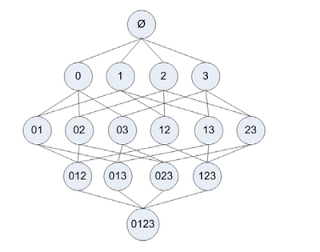

In [163]:
fig = Image(filename=('frequent-itemsets.png'))
fig

In [164]:
def createC1(dataset):
    "Create a list of candidate item sets of size one."
    c1 = []
    for transaction in dataset:
        for item in transaction:
            if not [item] in c1:
                c1.append([item])
    c1.sort()
    #frozenset because it will be a ket of a dictionary.
    return map(frozenset, c1)


def scanD(dataset, candidates, min_support):
    "Returns all candidates that meets a minimum support level"
    sscnt = {}
    for tid in dataset:
        for can in candidates:
            if can.issubset(tid):
                sscnt.setdefault(can, 0)
                sscnt[can] += 1

    num_items = float(len(dataset))
    retlist = []
    support_data = {}
    for key in sscnt:
        support = sscnt[key] / num_items
        if support >= min_support:
            retlist.insert(0, key)
        support_data[key] = support
    return retlist, support_data


def aprioriGen(freq_sets, k):
    "Generate the joint transactions from candidate sets"
    retList = []
    lenLk = len(freq_sets)
    for i in range(lenLk):
        for j in range(i + 1, lenLk):
            L1 = list(freq_sets[i])[:k - 2]
            L2 = list(freq_sets[j])[:k - 2]
            L1.sort()
            L2.sort()
            if L1 == L2:
                retList.append(freq_sets[i] | freq_sets[j])
    return retList


def apriori(dataset, minsupport=0.5):
    "Generate a list of candidate item sets"
    C1 = createC1(dataset)
    D = map(set, dataset)
    L1, support_data = scanD(D, C1, minsupport)
    L = [L1]
    k = 2
    while (len(L[k - 2]) > 0):
        Ck = aprioriGen(L[k - 2], k)
        Lk, supK = scanD(D, Ck, minsupport)
        support_data.update(supK)
        L.append(Lk)
        k += 1

    return L, support_data

## Choosing a minimum support
We run the Apriori algorithm on our slice of 10000 loaners (and their loans). We choose the minimum support to be 0.5%. The low minimum support is based on intuition as well as trial and error. A minimum support in the +10% range would be unrealistic given the fact that no book is loaned by that big a percentage of the entire population. If the algorithm should mine rules for a recommender system, the minimum support could be decreased to include not only the most popular titles. For this case, we are just interested in mining the strong rules of popular titles, so we keep the support threshold somewhat high given the nature of the data.

In [166]:
L, support_data = apriori(dataset, 0.005)

<a id="cell66"></a>
# Step 3: Mining association rules
Finally, relationships between itemsets (association rules) are considered in a similar fashion: First, we define a minimum confidence threshold. This threshold describes the minimum probability of which a consequent should occur given an antecedent. Consider the rule { book1 } -> { book2 } with a minimum confidence threshold of 10%. This means that if the rule is to meet our minimum confidence criteria, it should be the case that at least 10% of the people loaning book1 also loans book2 at some point in time (past or future). In the same way as before, we avoid looking at too many rule combinations by excluding subsets of itemsets in the rule.

In [167]:
def generateRules(L, support_data, min_confidence=0.7):
    """Create the association rules
    L: list of frequent item sets
    support_data: support data for those itemsets
    min_confidence: minimum confidence threshold
    """
    rules = []
    for i in range(1, len(L)):
        for freqSet in L[i]:
            H1 = [frozenset([item]) for item in freqSet]
            print "freqSet", freqSet, 'H1', H1
            if (i > 1):
                rules_from_conseq(freqSet, H1, support_data, rules, min_confidence)
            else:
                calc_confidence(freqSet, H1, support_data, rules, min_confidence)
    return rules


def calc_confidence(freqSet, H, support_data, rules, min_confidence=0.7):
    "Evaluate the rule generated"
    pruned_H = []
    for conseq in H:
        conf = support_data[freqSet] / support_data[freqSet - conseq]
        if conf >= min_confidence:
            print freqSet - conseq, '--->', conseq, 'conf:', conf
            rules.append((freqSet - conseq, conseq, conf))
            pruned_H.append(conseq)
    return pruned_H


def rules_from_conseq(freqSet, H, support_data, rules, min_confidence=0.7):
    "Generate a set of candidate rules"
    m = len(H[0])
    if (len(freqSet) > (m + 1)):
        Hmp1 = aprioriGen(H, m + 1)
        Hmp1 = calc_confidence(freqSet, Hmp1,  support_data, rules, min_confidence)
        if len(Hmp1) > 1:
            rules_from_conseq(freqSet, Hmp1, support_data, rules, min_confidence)

## Choosing a minimum confidence
The minimum confidence is set to 30% for this attempt at mining association rules. The same argument goes for this choice: We wanted to look at the strongest associations, with the possibility of expanding the set of rules by lowering the confidence threshold if we were to be in use of more (and weaker) association rules.

In [169]:
rules = generateRules(L,support_data,0.3)

freqSet frozenset(['870970-basis:51292200', '870970-basis:51270053']) H1 [frozenset(['870970-basis:51292200']), frozenset(['870970-basis:51270053'])]
freqSet frozenset(['870970-basis:28822030', '870970-basis:29060681']) H1 [frozenset(['870970-basis:28822030']), frozenset(['870970-basis:29060681'])]
freqSet frozenset(['870970-basis:28029608', '870970-basis:26765552']) H1 [frozenset(['870970-basis:28029608']), frozenset(['870970-basis:26765552'])]
frozenset(['870970-basis:26765552']) ---> frozenset(['870970-basis:28029608']) conf: 0.3
frozenset(['870970-basis:28029608']) ---> frozenset(['870970-basis:26765552']) conf: 0.586206896552
freqSet frozenset(['870970-basis:50657469', '870970-basis:29702446']) H1 [frozenset(['870970-basis:50657469']), frozenset(['870970-basis:29702446'])]
frozenset(['870970-basis:29702446']) ---> frozenset(['870970-basis:50657469']) conf: 0.532110091743
freqSet frozenset(['870970-basis:50789691', '870970-basis:50771423']) H1 [frozenset(['870970-basis:50789691']),

In [170]:
dfrules = DataFrame(rules)

In [171]:
len(dfrules)

54

In [172]:
dfrules.columns = ['antecedent','consequent','confidence']

In [173]:
for index,row in dfrules.iterrows():
    stri = str(row['antecedent']).split('\'')
    dfrules['antecedent'].loc[index] = stri[1]
    stri2 = str(row['consequent']).split('\'')
    dfrules['consequent'].loc[index] = stri2[1]

In [174]:
ant_titles = Series()
cons_titles = Series()

for index,row in dfrules.iterrows():
    ant_titles = ant_titles.append(books[books['materiale_id'] == row.antecedent].title)
    cons_titles = cons_titles.append(books[books['materiale_id'] == row.consequent].title)

In [175]:
ant_titles.index = np.arange(0,len(ant_titles))
cons_titles.index = np.arange(0,len(ant_titles))

ant_titles.columns = ['ant_title']
cons_titles.columns = ['cons_title']

In [176]:
dfrules = pd.concat([dfrules,ant_titles,cons_titles],1)
dfrules = dfrules.sort('confidence', ascending=False)
dfrules.columns = ['antecedent','consequent','confidence','antetitle','constitle']

C:\Users\Jonatan\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


In [177]:
dfrules

,antecedent,consequent,confidence,antetitle,constitle
52,870970-basis:24765210,870970-basis:27047548,0.714286,Norge,Turen går til Norge
39,870970-basis:29066019,870970-basis:28607857,0.670103,Flere hæklede dyr,Hæklede dyr
38,870970-basis:28607857,870970-basis:29066019,0.663265,Hæklede dyr,Flere hæklede dyr
17,870970-basis:26176972,870970-basis:26820359,0.590909,Politikens visuelle guide - London,Turen går til London
1,870970-basis:28029608,870970-basis:26765552,0.586207,Politikens visuelle guide - Barcelona & Catalo...,Turen går til Barcelona og Costa Brava
10,870970-basis:27288146,870970-basis:28414897,0.563830,Politikens Kort og godt om Berlin,Politikens visuelle guide - Berlin
25,125610-katalog:20035862,820010-katalog:2351249,0.545455,Rejsen over stepperne,Hulebjørnens klan
34,870970-basis:28557590,870970-basis:27474659,0.533333,Strik en stund,Strik naturligvis!
2,870970-basis:29702446,870970-basis:50657469,0.532110,Axel Strøbye : en tragisk komedie,Ikke et sekund spildt
3,870970-basis:51161165,870970-basis:29537011,0.504098,"Kærligheden, kampen og kloden : en erindringsd...","Jesus, pengene og livet"


<a id="cell40"></a>
# Visuals

### Initial bar charts
The first three visualizations; top 25, ages of book readers and book loans during the year were made as bar charts to allow the viewer to quickly get an overview of the dataset. The drop-down menu and transitions were added to give the viewer a chance to explore the data in his own way, and dive into the characteristics of a particular book and tell their own story. 

<a id="cell41"></a>
### Map of municipals
The municipal map was created using a .json file of the municipals and matching it with library book data. Initially, the library data wasn’t divided into municipals, but zip codes. Since we have about 600 different zip codes in Denmark, the resulting map was very hard to tell anything from. We chose to do the work of matching zip-code with libraries to give the viewer an easy overview of the popularity of a specific category in their municipal. The dynamically changes with the chosen dataset, so that the viewer can compare the popularity of a category across municipals, and see if the given category is more or less popular in his municipal than the neighboring one. Imagine a library manager looking at the map and using it for exchanging books with his colleagues. The color scale is a standard colorbrewer scale that is informative and pleasant to look at. The darker the municipal, the greater amount of books are lend there. The hover effect with the name of municipal and exact percentage was added to allow the user to get exact details on top of the overview, and is a very useful feature if you, like many others, are not sure of the municipals’ exact geography.

<a id="cell42"></a>
### KNN Map
Though the municipal map is nice, it’s obvious that there’s a lot of missing data. Out of 99 municipals we only had data for 49. We used machine learning to overcome this issue. We did a KNN map with a grid of 100x100 points placed on top of the municipal map to visualize the machine learning. The color scale is not gradual but buckets of distinguishable colors.

<a id="cell43"></a>
### Association rules
The network graph of the rules gives the viewer a nice overview of how the titles are related in terms of likelyhood that lending one book will also lead to the lending of another. Each connection is displayed with an arrow pointing to and from the related titles, and the titles with most rules applied to those are closest to the centre. The probability is shown on the arrow. It gives a nice overview of what titles often lead to other specific books. If book A often leads to a loan of book B, and the library doesn't own book B, our visualisation can help the library decide to purchase book B in order to meet potential customer demand that they are unaware of.

<a id="cell50"></a>

# Discussion
<a id="cell51"></a>
## Good stuff
**A broad view**
The amount of data is huge, likewise is the range of possible patterns to look for. We've explored how a broad range of different parameters influence the loan tendencies; age, time of the year, gender, location and more. Likewise we've visualised this data in different bar graphs, histograms, geojson maps, overlay grids and network associations. We've experimented with several different machine learning algorithms to test where there's a potential - and where it doesn't make sense to apply. Overall we believe our work presents a range of different paths that could serve as inspiration for further work, that will lead to usefull tools for libraries. 

**A delicious map**
We are quite satisfied with our d3 map of Denmark. It provides a good overview of the regional differences and looks crisp. Datawise it's a bummer that we lack library data from 1/2 of all municipalities.

**Associations**
The associations mining has worked out really well. The outcome is limited by our computing power, but shows interesting connections. Some of the rules found are somewhat obvious, but others does unquestionably provide new knowledge to libarians and would be a usefull tool for expanding the current book selection.


<a id="cell52"></a>
## Less good stuff

**Not much of a tool**
The flipside of our a broad view, is that our project doesn't provide a single in depth tool that can be directly applied by libarians. The best use case scenario of our project would be as an eye opener that could be used in dialogue with libaries to figure out what direction would make the most sense to focus on.

**Understanding the KNN algorithm**
As we've used the KNN algorithm somewhat "backwards" we've struggled to figure out how it deals with labeling a point of the nearest neighbour if NN is 100 points, and k is <100. Having read through documentation and done several experiments, it seems to come down to an "argpartition" function within the brute force algorithm, which we find hard to figure out the logic of. The result is that we aren't quite sure how this model actually interprets our data, which creates uncertainties of how accurate the map is.



<a id="cell53"></a>
## Further work
From our work we believe the largest potential lies within the associations mapping. Further work could include doing some heavy machine learning on the entire dataset of users, and creating a searchable tool in which librarians can simply input a title, and get sugestions for titles that work well along with the book input.

Another simple, but usable tool, would be to create a searchable database of the most popular books within a genre, for a certain gender and age group. If a library would like to attract more loaners of a specific demographic, they could simply input the age, sex and potentially genre which they would invest in, and the database would return top x titles for this group which could serve as a guidance for new book purchases. This tool could also be combined with the association mapping, so that it based on the current books at the library, suggested the books most likely to get lend out for this specific group.